## Import Library and Acquire Work Directory

In [1]:
# system library
import os
import glob
import shutil
from importlib import reload

# 3rd party library
import numpy as np
import pandas as pd
import lmfit
import KiMoPack.plot_func as pf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# user library
import min_function as mf
import min_instrument as mins
import min_math as mm
import min_plot as mp

# acquire current work directory
cwd = os.getcwd()
print(f"\nCurrent Work Directory:\n{cwd}")

# acquire filename from current work directory
fn = os.path.basename(cwd)
fn = fn.split("_")
fn = "_".join(fn[0:2])
print(f"\nFilename:\n{fn}")

# remove the folders
# shutil.rmtree("Scans")
# shutil.rmtree("result_figures")
# shutil.rmtree("p2")
# shutil.rmtree("g2")
# shutil.rmtree("t2")

Qt was found consider switching to qt mode with %matplotlib qt (more comfortable)
Plot_func version 7.4.0
was imported from path:
 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/KiMoPack
The current working folder is:
 /Users/tm/Downloads/sample_solvent_ar_fsta_330ex_caf2_100uw_it1000ms_depolarizer

Current Work Directory:
/Users/tm/Downloads/sample_solvent_ar_fsta_330ex_caf2_100uw_it1000ms_depolarizer

Filename:
sample_solvent


# Preprocess

In [ ]:
# acquire the filepath of each scan
fps_scan = glob.glob(f"{cwd}/*/*.GUI.csv")
fps_scan.sort()
print(f"\n{len(fps_scan)} scans were found:")
for fp_scan in fps_scan:
    print(os.path.basename(fp_scan))

# create the Scans folder for storing the processed data
os.makedirs(f"{cwd}/Scans", exist_ok=True)

## Process Each Scan

In [ ]:
# create the ls_scan list for storing the processed dataframe
ls_scan = []
# fps_scan = fps_scan[0:1]  # for testing, only process the first scan
for fp_scan in fps_scan:
    print(f"\nCurrent scan:\n{os.path.basename(fp_scan)}")

    # modify the filename
    (dir_scan, fn_scan) = os.path.split(fp_scan)
    fn_scan = os.path.basename(fp_scan)
    fn_scan = fn_scan.split(".")
    scan_count = ((fn_scan[1].split("_"))[-1]).lower()
    fn_scan = fn_scan[0] + "_" + scan_count
    # fn_scan = fn_scan.replace("uvpr", "caf2")  # adjust this line for proper filename
    print(f"\nModified Filename:\n{fn_scan}")

    # import raw data in mOD
    scan_df = pd.read_csv(fp_scan, header=0, index_col=0, na_values="NaN", sep=",")
    scan_df = scan_df * 1000  # convert OD to mOD
    scan_df.columns = [float(i) for i in scan_df.columns]
    print(
        f"\nRaw fs-TA data, \033[1m{len(np.where(scan_df.isna())[0])} NaN point\033[0m:"
    )
    # display(scan_df)
    mp.display_fsta_heatmap(scan_df).show()
    mins.writeSXUfs(
        scan_df,
        f"Scans/{fn_scan}_raw.ufs",
    )

    # crop the data to the wl_range
    wl_range = [330, 750]
    tailored_scan_df = mins.tailor_fsta(scan_df, wl_range)
    tailored_scan_df = scan_df.loc[
        (scan_df.index >= wl_range[0]) & (scan_df.index <= wl_range[1])
    ]
    print(
        f"\nTailored raw fs-TA data, \033[1m{len(np.where(tailored_scan_df.isna())[0])} NaN points\033[0m:"
    )
    # display(tailored_scan_df)
    # mp.display_fsta_heatmap(tailored_scan_df).show()
    mins.writeSXUfs(
        tailored_scan_df,
        f"Scans/{fn_scan}_{wl_range[0]}{wl_range[1]}.ufs",
    )

    # repair NaN points
    rpnan_tailored_scan_df = tailored_scan_df.interpolate(
        method="linear", limit_direction="both", axis=0
    )  # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
    print(
        f"Repaired tailored raw fs-TA data, \033[1m{len(np.where(rpnan_tailored_scan_df.isna())[0])} NaN point\033[0m:"
    )
    # display(rpnan_tailored_scan_df)
    # mp.display_fsta_heatmap(rpnan_tailored_scan_df).show()
    mins.writeSXUfs(
        rpnan_tailored_scan_df,
        f"Scans/{fn_scan}_{wl_range[0]}{wl_range[1]}_rpnan.ufs",
    )

    # store each scan in ls_scan
    ls_scan.append(rpnan_tailored_scan_df)

## Compare Each Scan


In [ ]:
ref_scan_num = 0
for i in range(1, len(ls_scan)):
    scan_diff = mins.compare_scan_fsta(ls_scan[ref_scan_num], ls_scan[i])
    mp.display_fsta_heatmap(scan_diff, zlimit=[-2, 2, 0.1]).show()
    mins.writeSXUfs(
        scan_diff,
        f"Scans/{fn}_diff{i}{ref_scan_num}.ufs",
    )

## Reaverage Data

In [ ]:
average_fsta = mins.reaverage_fsta(ls_scan[:3])
# display(average_fsta)
mp.display_fsta_heatmap(average_fsta).show()
mins.writeSXUfs(
    average_fsta,
    f"Scans/{fn}_rna_rav.ufs",
)

## Subtract Background

In [ ]:
sub_bg_fsta = mins.subtract_background_fsta(average_fsta, [-100, -2])
# display(sub_bg_fsta)
mp.display_fsta_heatmap(sub_bg_fsta).show()
mins.writeSXUfs(
    sub_bg_fsta,
    f"Scans/{fn}_rna_rav_sbg.ufs",
)

# Visualize


In [2]:
sample = f"Sample"  # legend name shown in figure
fp = glob.glob(f"{cwd}/*.ufs")[0]  # only one .ufs file in the current work directory
data = mins.load_fsta(fp)

data = data.iloc[:, 1:]  # remove the first column, usually contains NaN points
nan = np.where(data.isna())  # check if there is NaN points
display(nan)
display(data)

# acquire the maximum and minimum values for setting the mOD range
globalmax = data.max().max()
globalmin = data.min().min()
localmax = mins.tailor_fsta(data, [355, 700], [0.3, 8000]).max().max()
localmin = mins.tailor_fsta(data, [355, 700], [0.3, 8000]).min().min()
print(
    f"globalmax: {globalmax}\nglobalmin: {globalmin}\nlocalmax: {localmax}\nlocalmin: {localmin}"
)

(array([534]), array([500]))

,-98.504697,-96.504700,-94.503823,-92.504439,-90.505518,-88.502186,-86.503470,-84.503491,-82.502649,-80.502590,...,7099.509186,7199.503696,7299.521787,7399.496515,7499.526739,7599.528009,7699.512646,7799.550092,7899.506016,7999.493178
330.0,0.711822,0.640295,0.699101,0.828740,-7.117019,-6.741493,-2.178038,-1.221509,1.327394,0.671069,...,-3.785950,-3.821055,-3.531776,-4.321805,-3.377413,-2.185612,-2.827799,-2.496235,-3.718021,-3.587375
330.8,0.663499,0.650663,0.869818,1.032298,-6.386594,-6.208681,-1.414323,-0.827979,0.764366,0.631519,...,-3.718399,-4.017114,-3.979935,-2.780532,-2.946883,-2.998421,-2.499269,-3.388136,-3.536570,-3.758808
331.6,1.177564,1.063890,0.583907,0.471918,-5.967452,-5.716711,-2.171056,-1.380484,0.491226,0.073269,...,-3.911993,-4.129818,-4.190311,-3.540598,-3.874351,-3.076339,-3.181142,-2.829483,-3.425921,-3.879341
332.4,0.643062,0.413220,0.414438,0.457408,-5.445368,-4.625204,-1.442487,-1.267601,0.353482,0.400844,...,-3.378786,-3.779776,-3.899074,-4.027630,-3.312434,-2.928301,-3.003746,-3.815642,-3.674188,-4.174171
333.2,0.517292,0.154818,0.457742,0.790606,-4.348521,-4.037361,-1.277935,-0.545351,0.832129,0.162490,...,-3.171439,-3.695750,-4.037154,-3.939825,-3.488365,-3.560539,-3.042988,-3.744436,-2.998139,-3.427573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746.6,-0.077246,-0.098307,0.016279,0.100630,-0.010920,-0.094937,0.089571,-0.002931,0.087960,-0.032915,...,-0.006981,0.309010,0.059017,0.145013,0.464343,0.069352,0.595007,0.082686,0.306678,0.452345
747.4,-0.026013,-0.066676,0.008939,0.073611,-0.005992,-0.030017,0.058600,-0.004999,0.053947,0.032316,...,-0.004694,-0.069360,0.012639,0.104972,0.002307,-0.047693,-0.021361,-0.016027,-0.005694,0.048972
748.2,-0.024327,-0.062676,0.000294,0.052964,-0.020998,-0.032350,0.015965,-0.008346,-0.045343,0.057949,...,-0.020020,-0.059687,0.010646,-0.009687,-0.000687,-0.030687,-0.035020,-0.002687,-0.044687,-0.000021
748.9,0.005456,-0.012208,0.000787,0.012454,0.002124,-0.031872,-0.006881,-0.007877,0.008120,-0.008209,...,0.002789,-0.007211,-0.023211,-0.021544,-0.000211,0.013456,0.021122,-0.005877,-0.005211,-0.004211


globalmax: 12.272308
globalmin: -13.1612414
localmax: 10.4760917
localmin: -0.1018449


## 2D Map


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/tm/Downloads/sample_solvent_ar_fsta_330ex_caf2_100uw_it1000ms_depolarizer/min_function.py:673: RuntimeWarning: divide by zero encountered in divide
  e3cm1 = 10**4 / nm


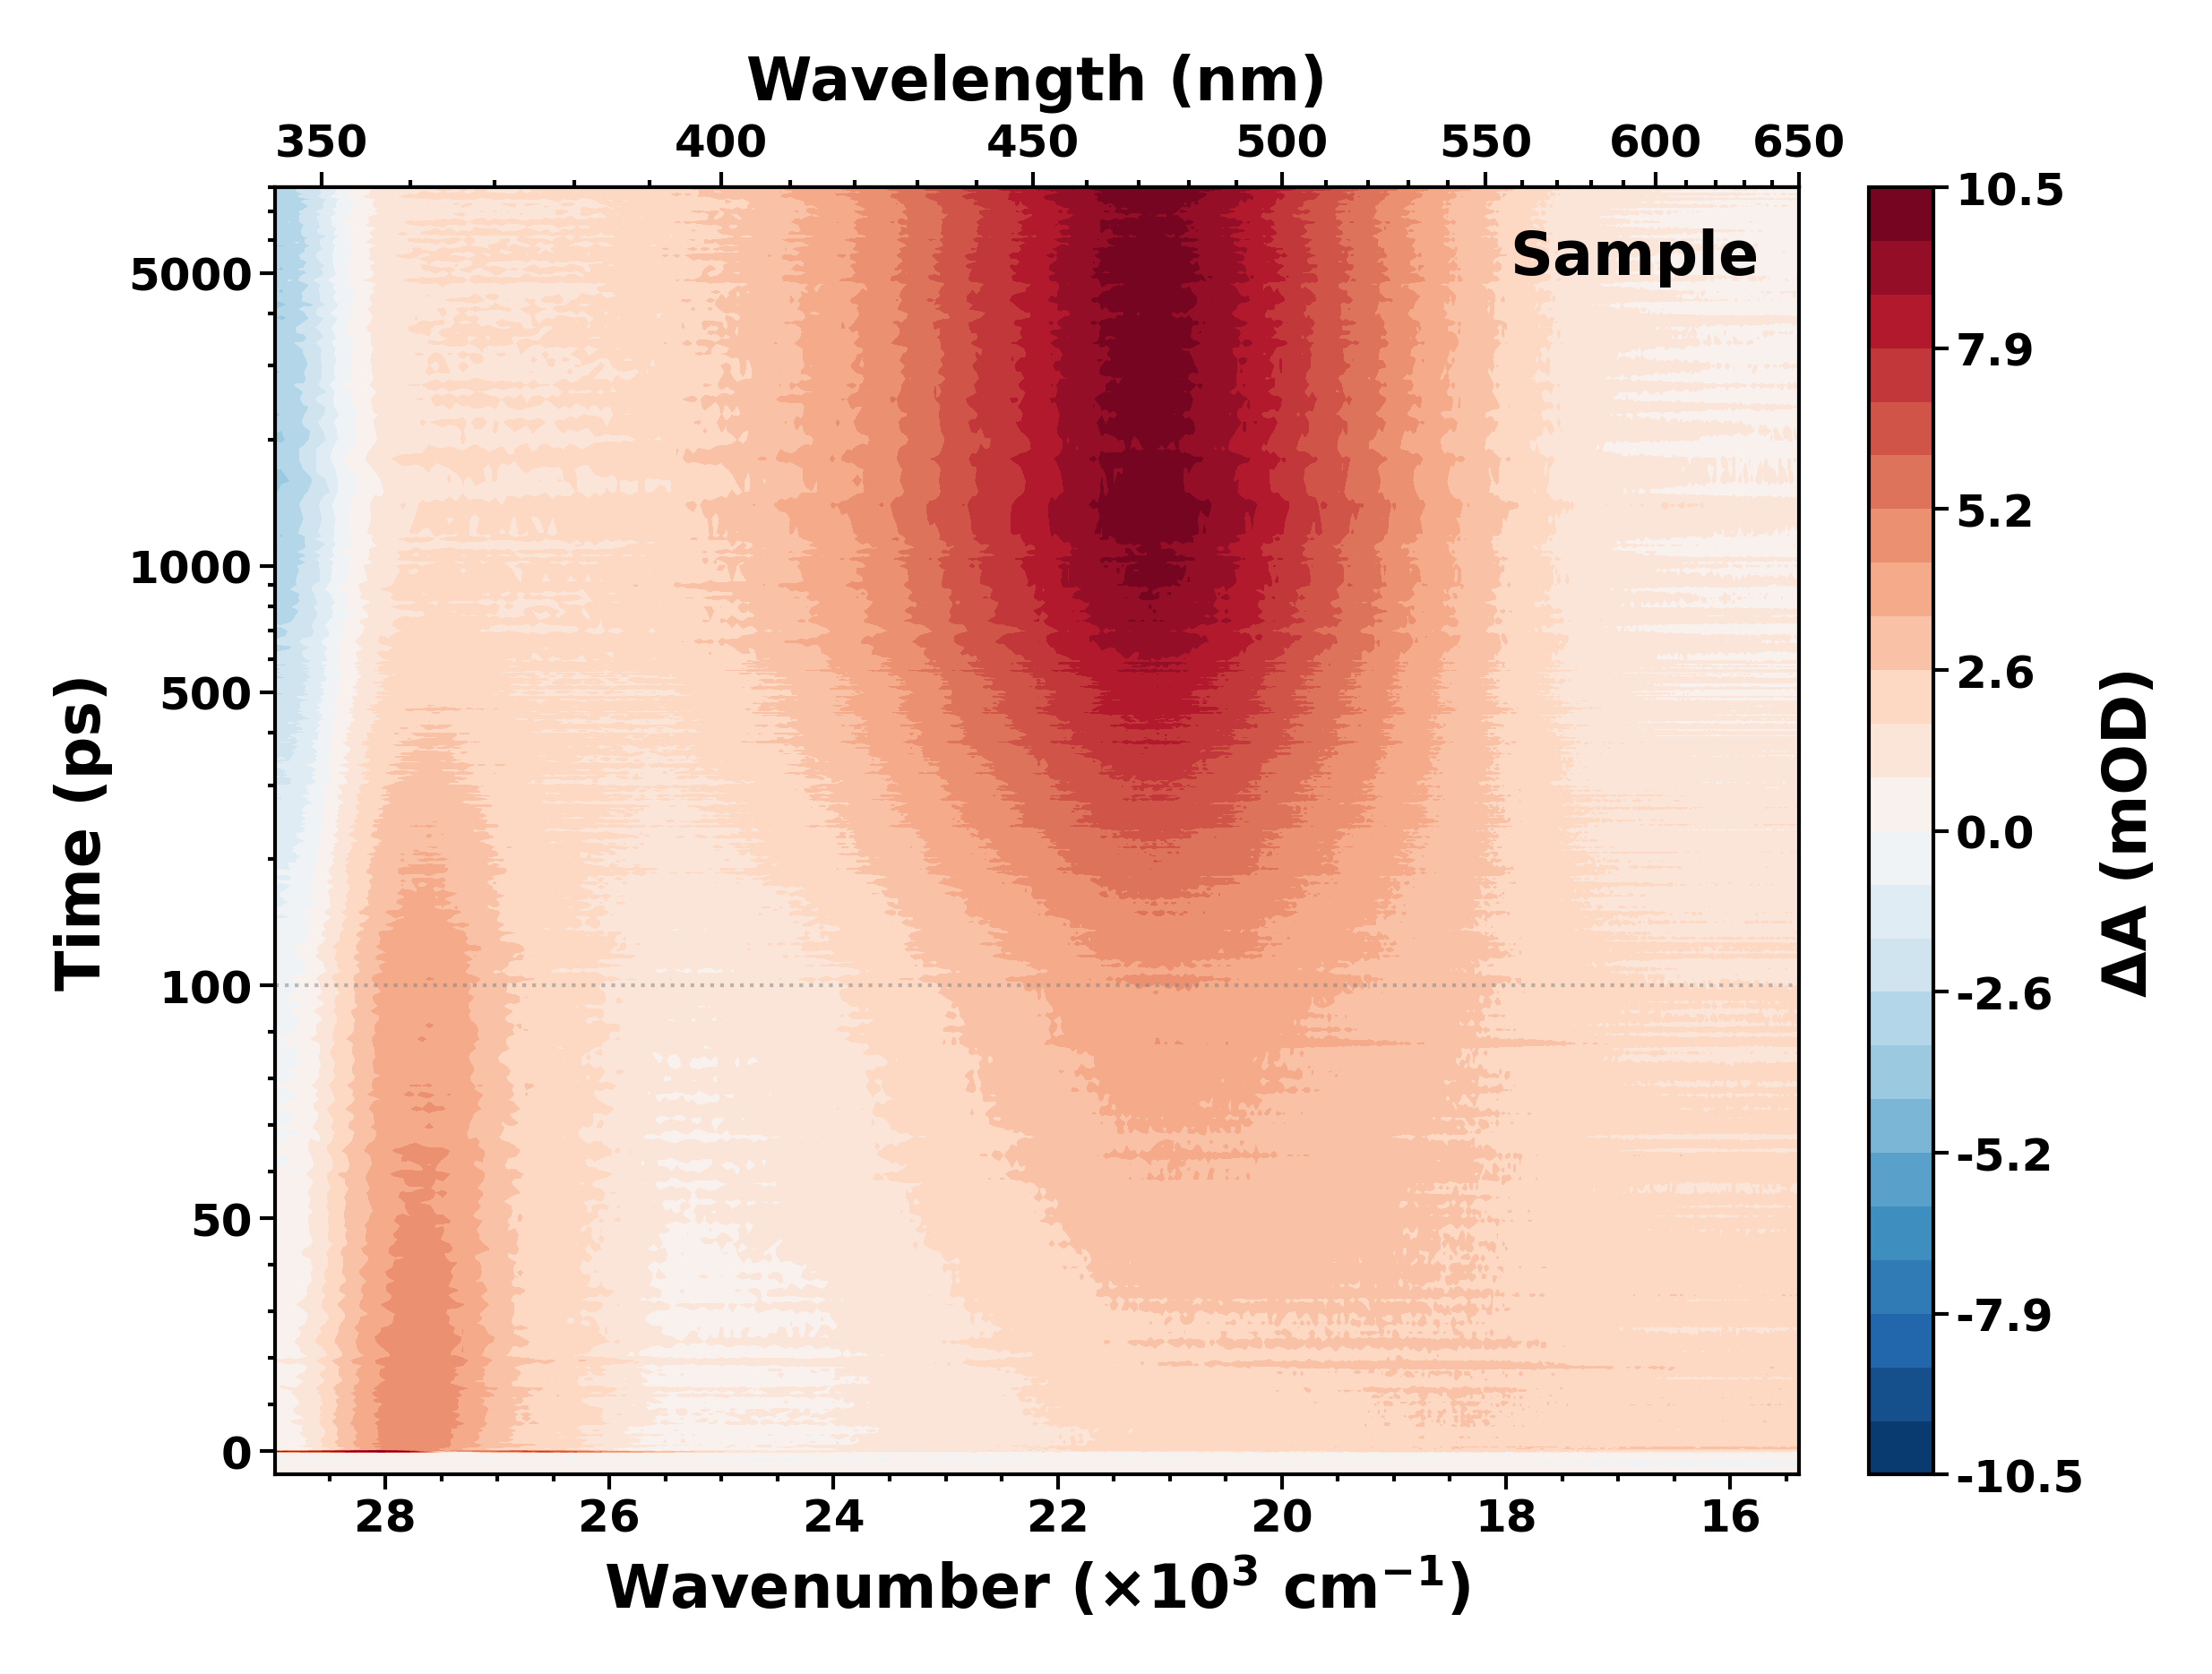

In [3]:
# reload(mp)
# mp.display_fsta_heatmap_linear(data).show()

nm_limit = [[345, 650], 50, 10]  # set the wavelength range
e3cm1_limit = [
    [mf.e3cm1_to_nm(nm_limit[0][0]), mf.e3cm1_to_nm(nm_limit[0][1])],
    2,
    0.5,
]  # convert to 10**3 wavenumber
t_limit = [[-5, 100, 8000], 50, 10]  # set the time window
od_limit = [[-localmax, localmax], 2, 1]  # set the mOD range

contour_bwn_twl = mp.display_fsta_contourf_symlog_be3cm1_tnm(
    df_fsta=data,
    legendtitle=sample,
    xlimit=e3cm1_limit,
    xlimit2=nm_limit,
    ylimit=t_limit,
    zlimit=od_limit,
)
plt.show()

## Spectra


/Users/tm/Downloads/sample_solvent_ar_fsta_330ex_caf2_100uw_it1000ms_depolarizer/min_function.py:673: RuntimeWarning: divide by zero encountered in divide
  e3cm1 = 10**4 / nm


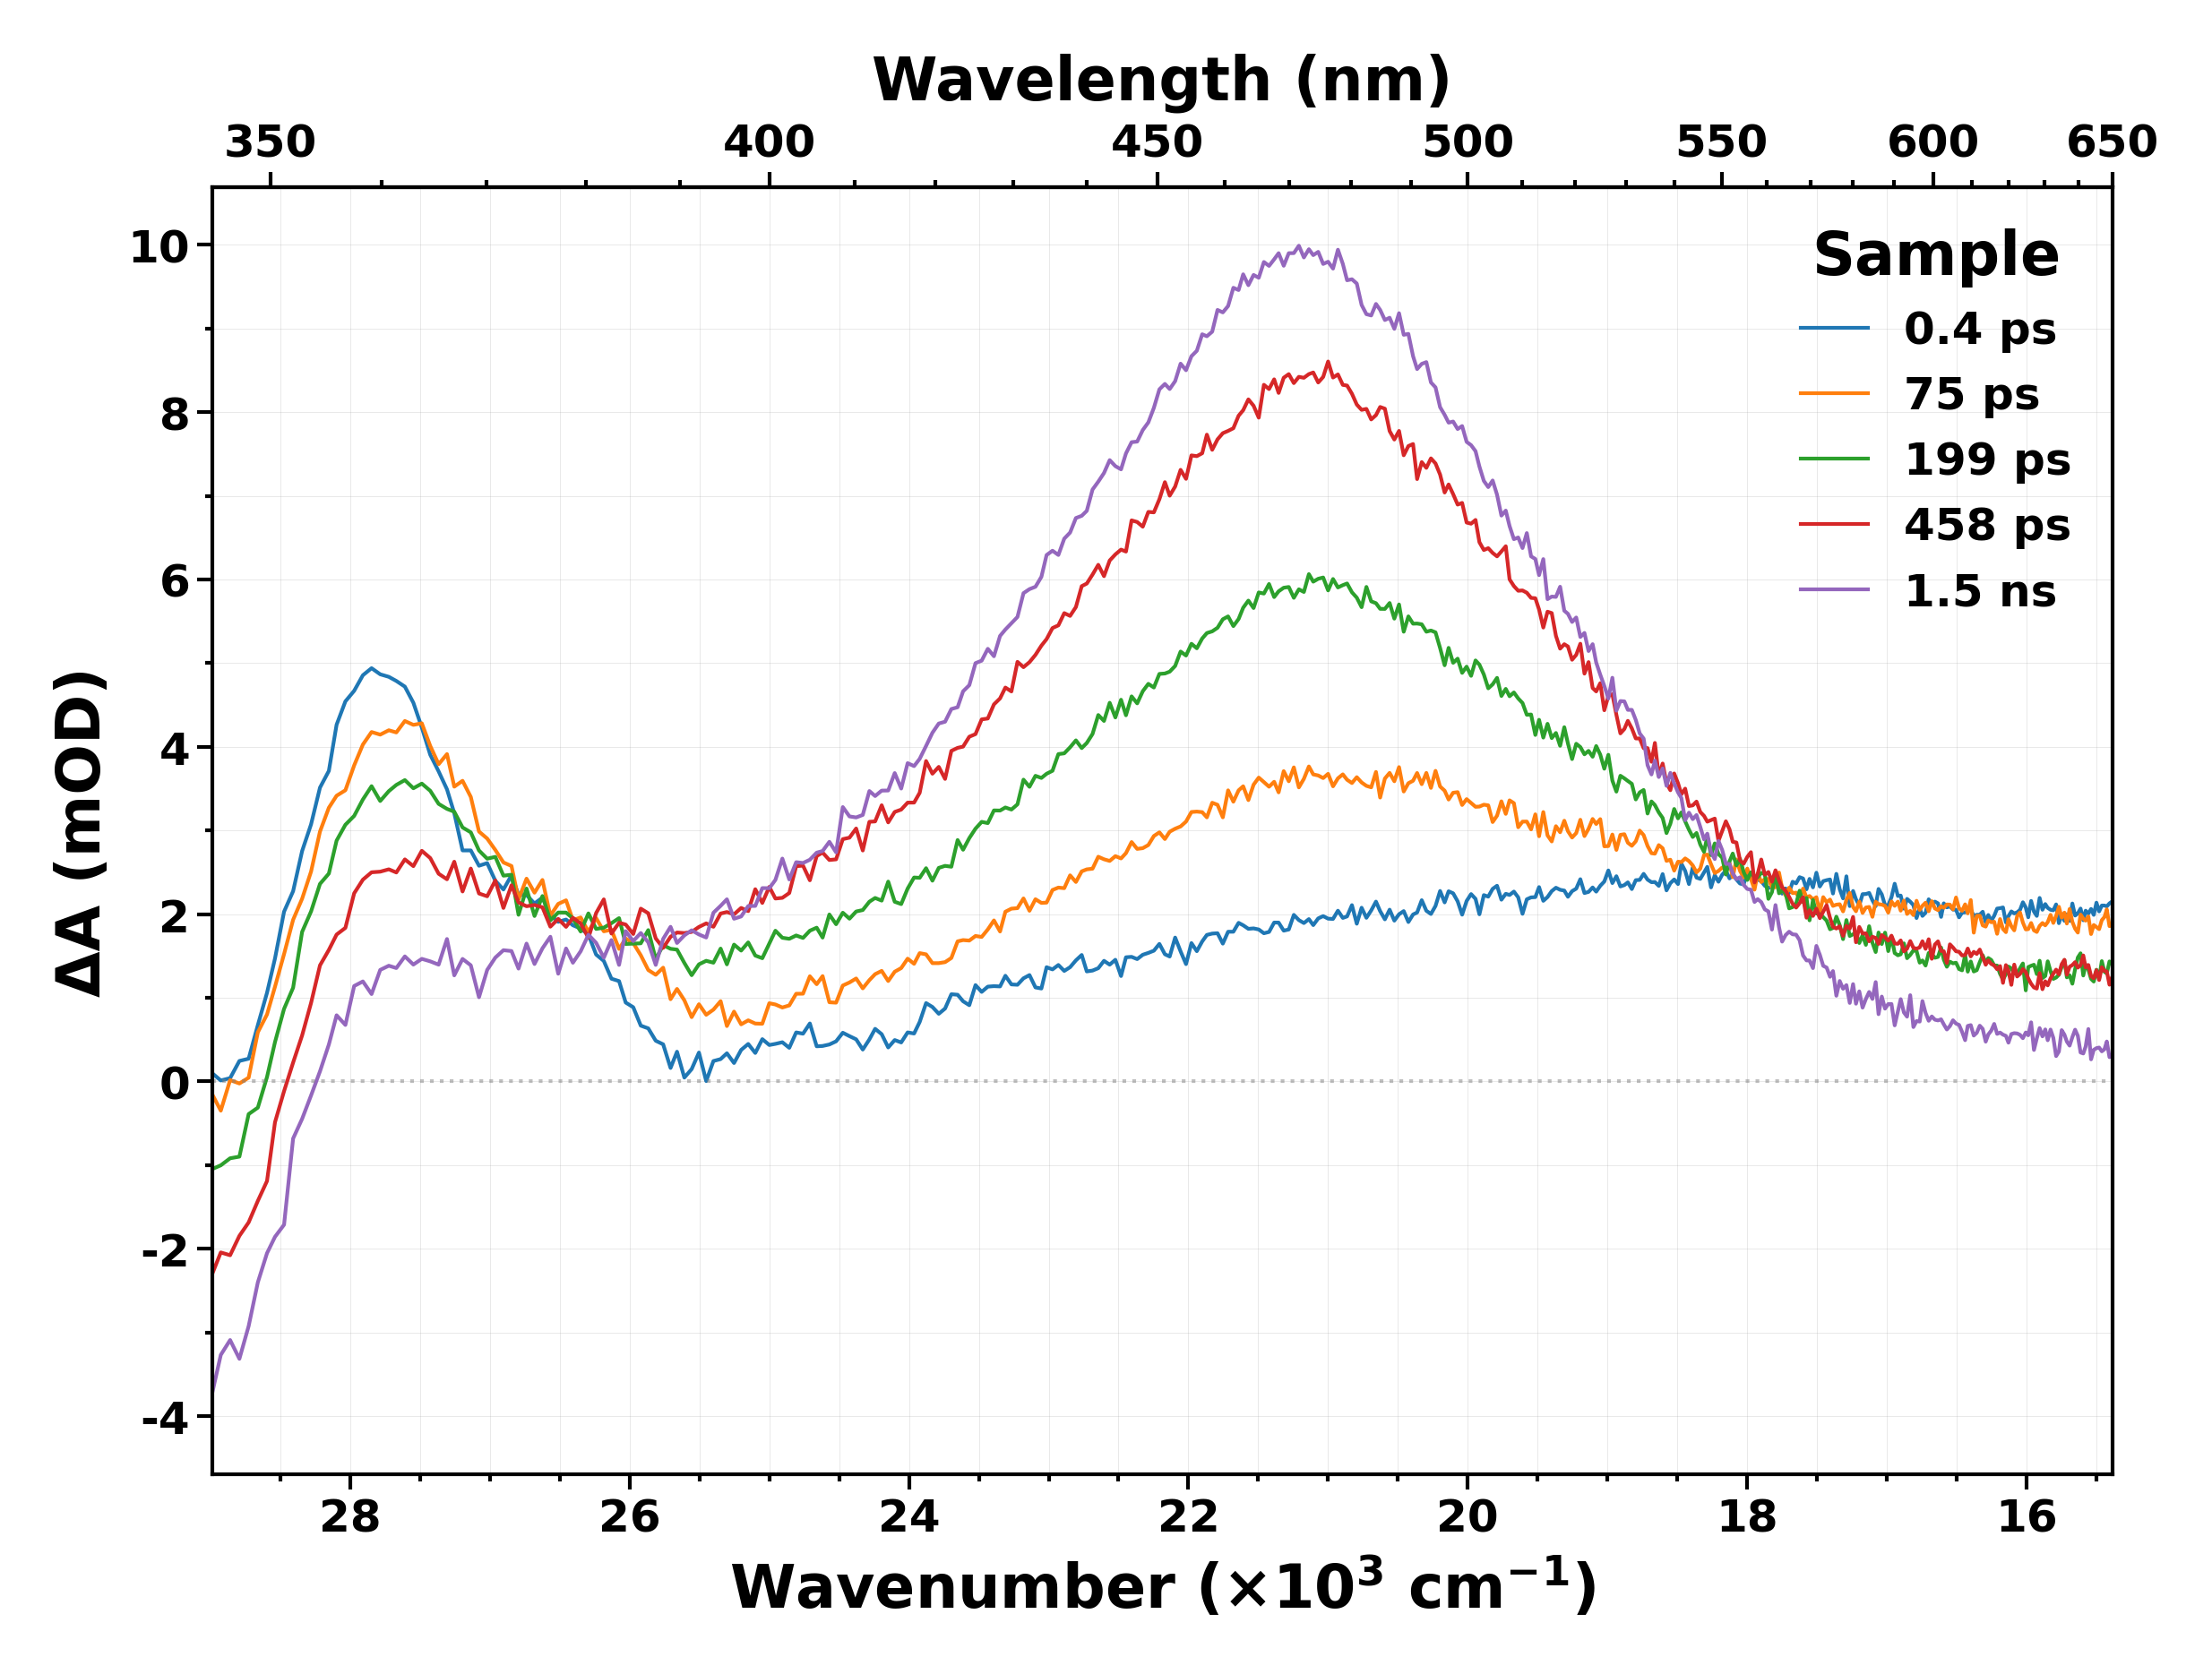

/Users/tm/Downloads/sample_solvent_ar_fsta_330ex_caf2_100uw_it1000ms_depolarizer/min_function.py:673: RuntimeWarning: divide by zero encountered in divide
  e3cm1 = 10**4 / nm


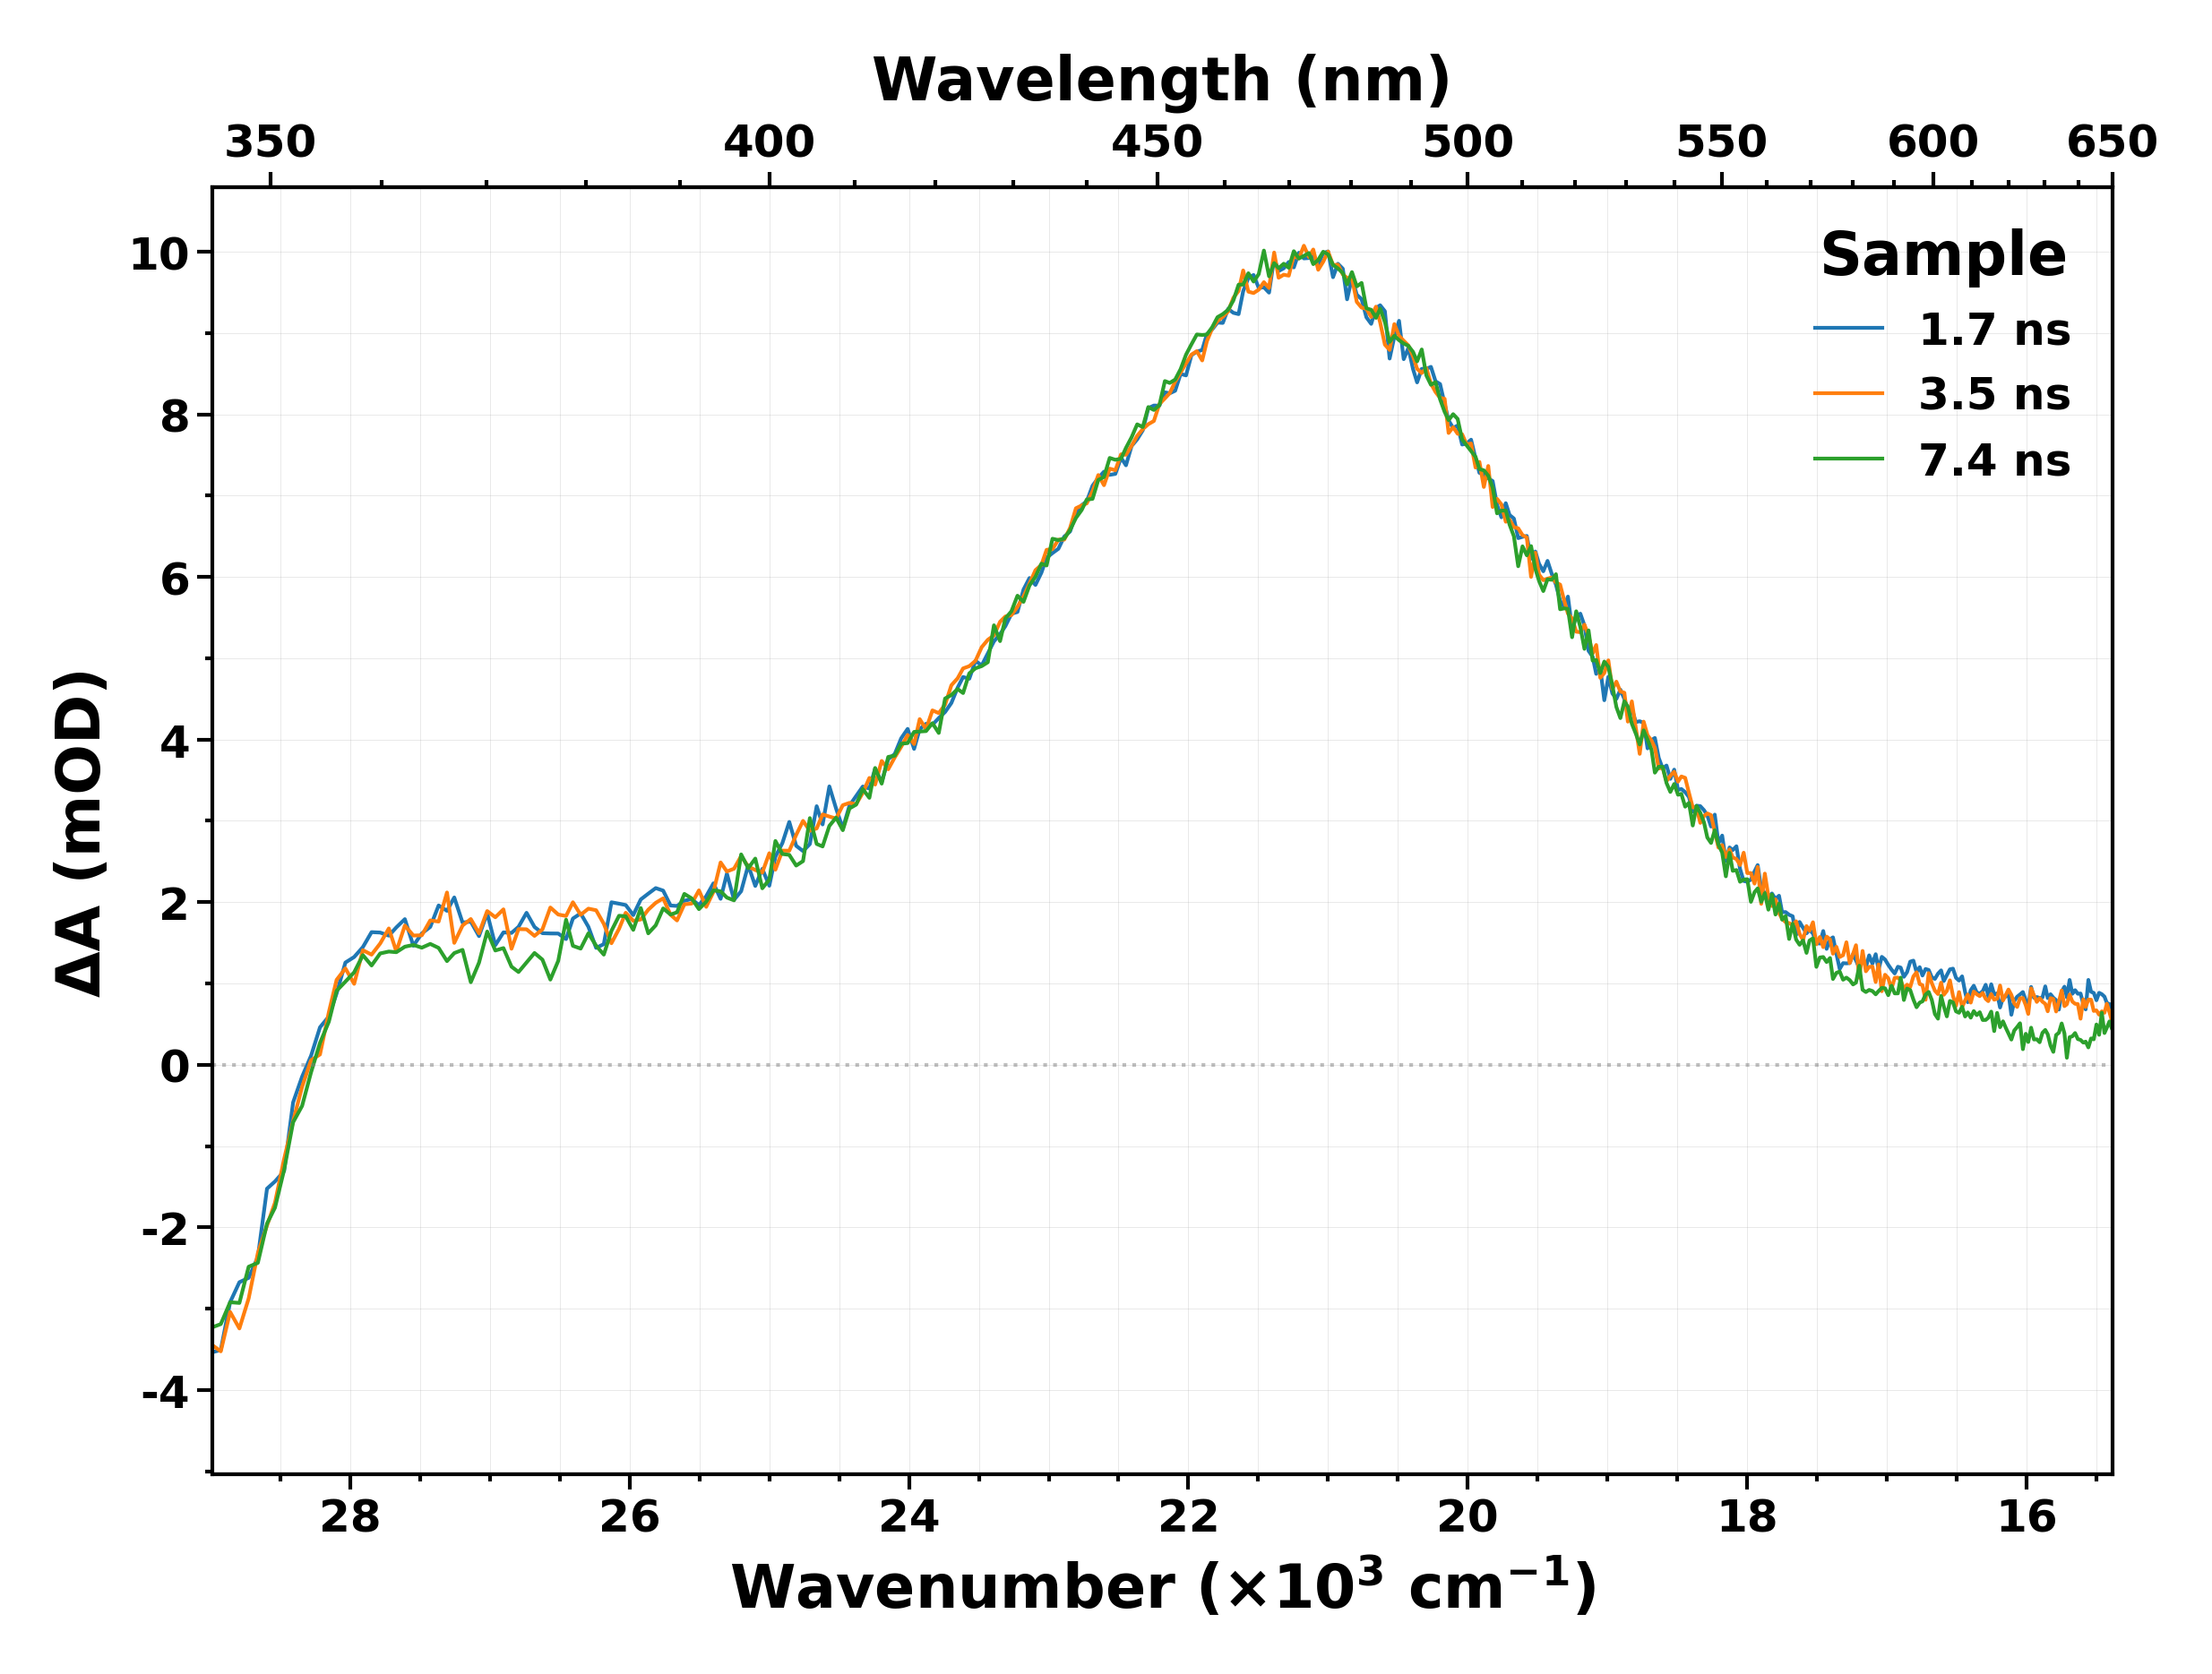

In [4]:
# reload(mp)

delaytime1 = [0.445, 75.3, 200, 457, 1500]  # set the delay time 1
spectra1 = mins.extract_spectra_trspectra(data, delaytime1)
# display(spectra1)
fstas_bwn_twl = mp.display_fsta_spectra_be3cm1_tnm(
    df_fstas_wl=spectra1,
    legendtitle=sample,
    xlimit=e3cm1_limit,
)
plt.show()

delaytime2 = [1710, 3490, 7370]  # set the delay time 2
spectra2 = mins.extract_spectra_trspectra(data, delaytime2)
# display(spectra2)
fstas_bwn_twl2 = mp.display_fsta_spectra_be3cm1_tnm(
    df_fstas_wl=spectra2,
    legendtitle=sample,
    xlimit=e3cm1_limit,
)
plt.show()

## Kinetics


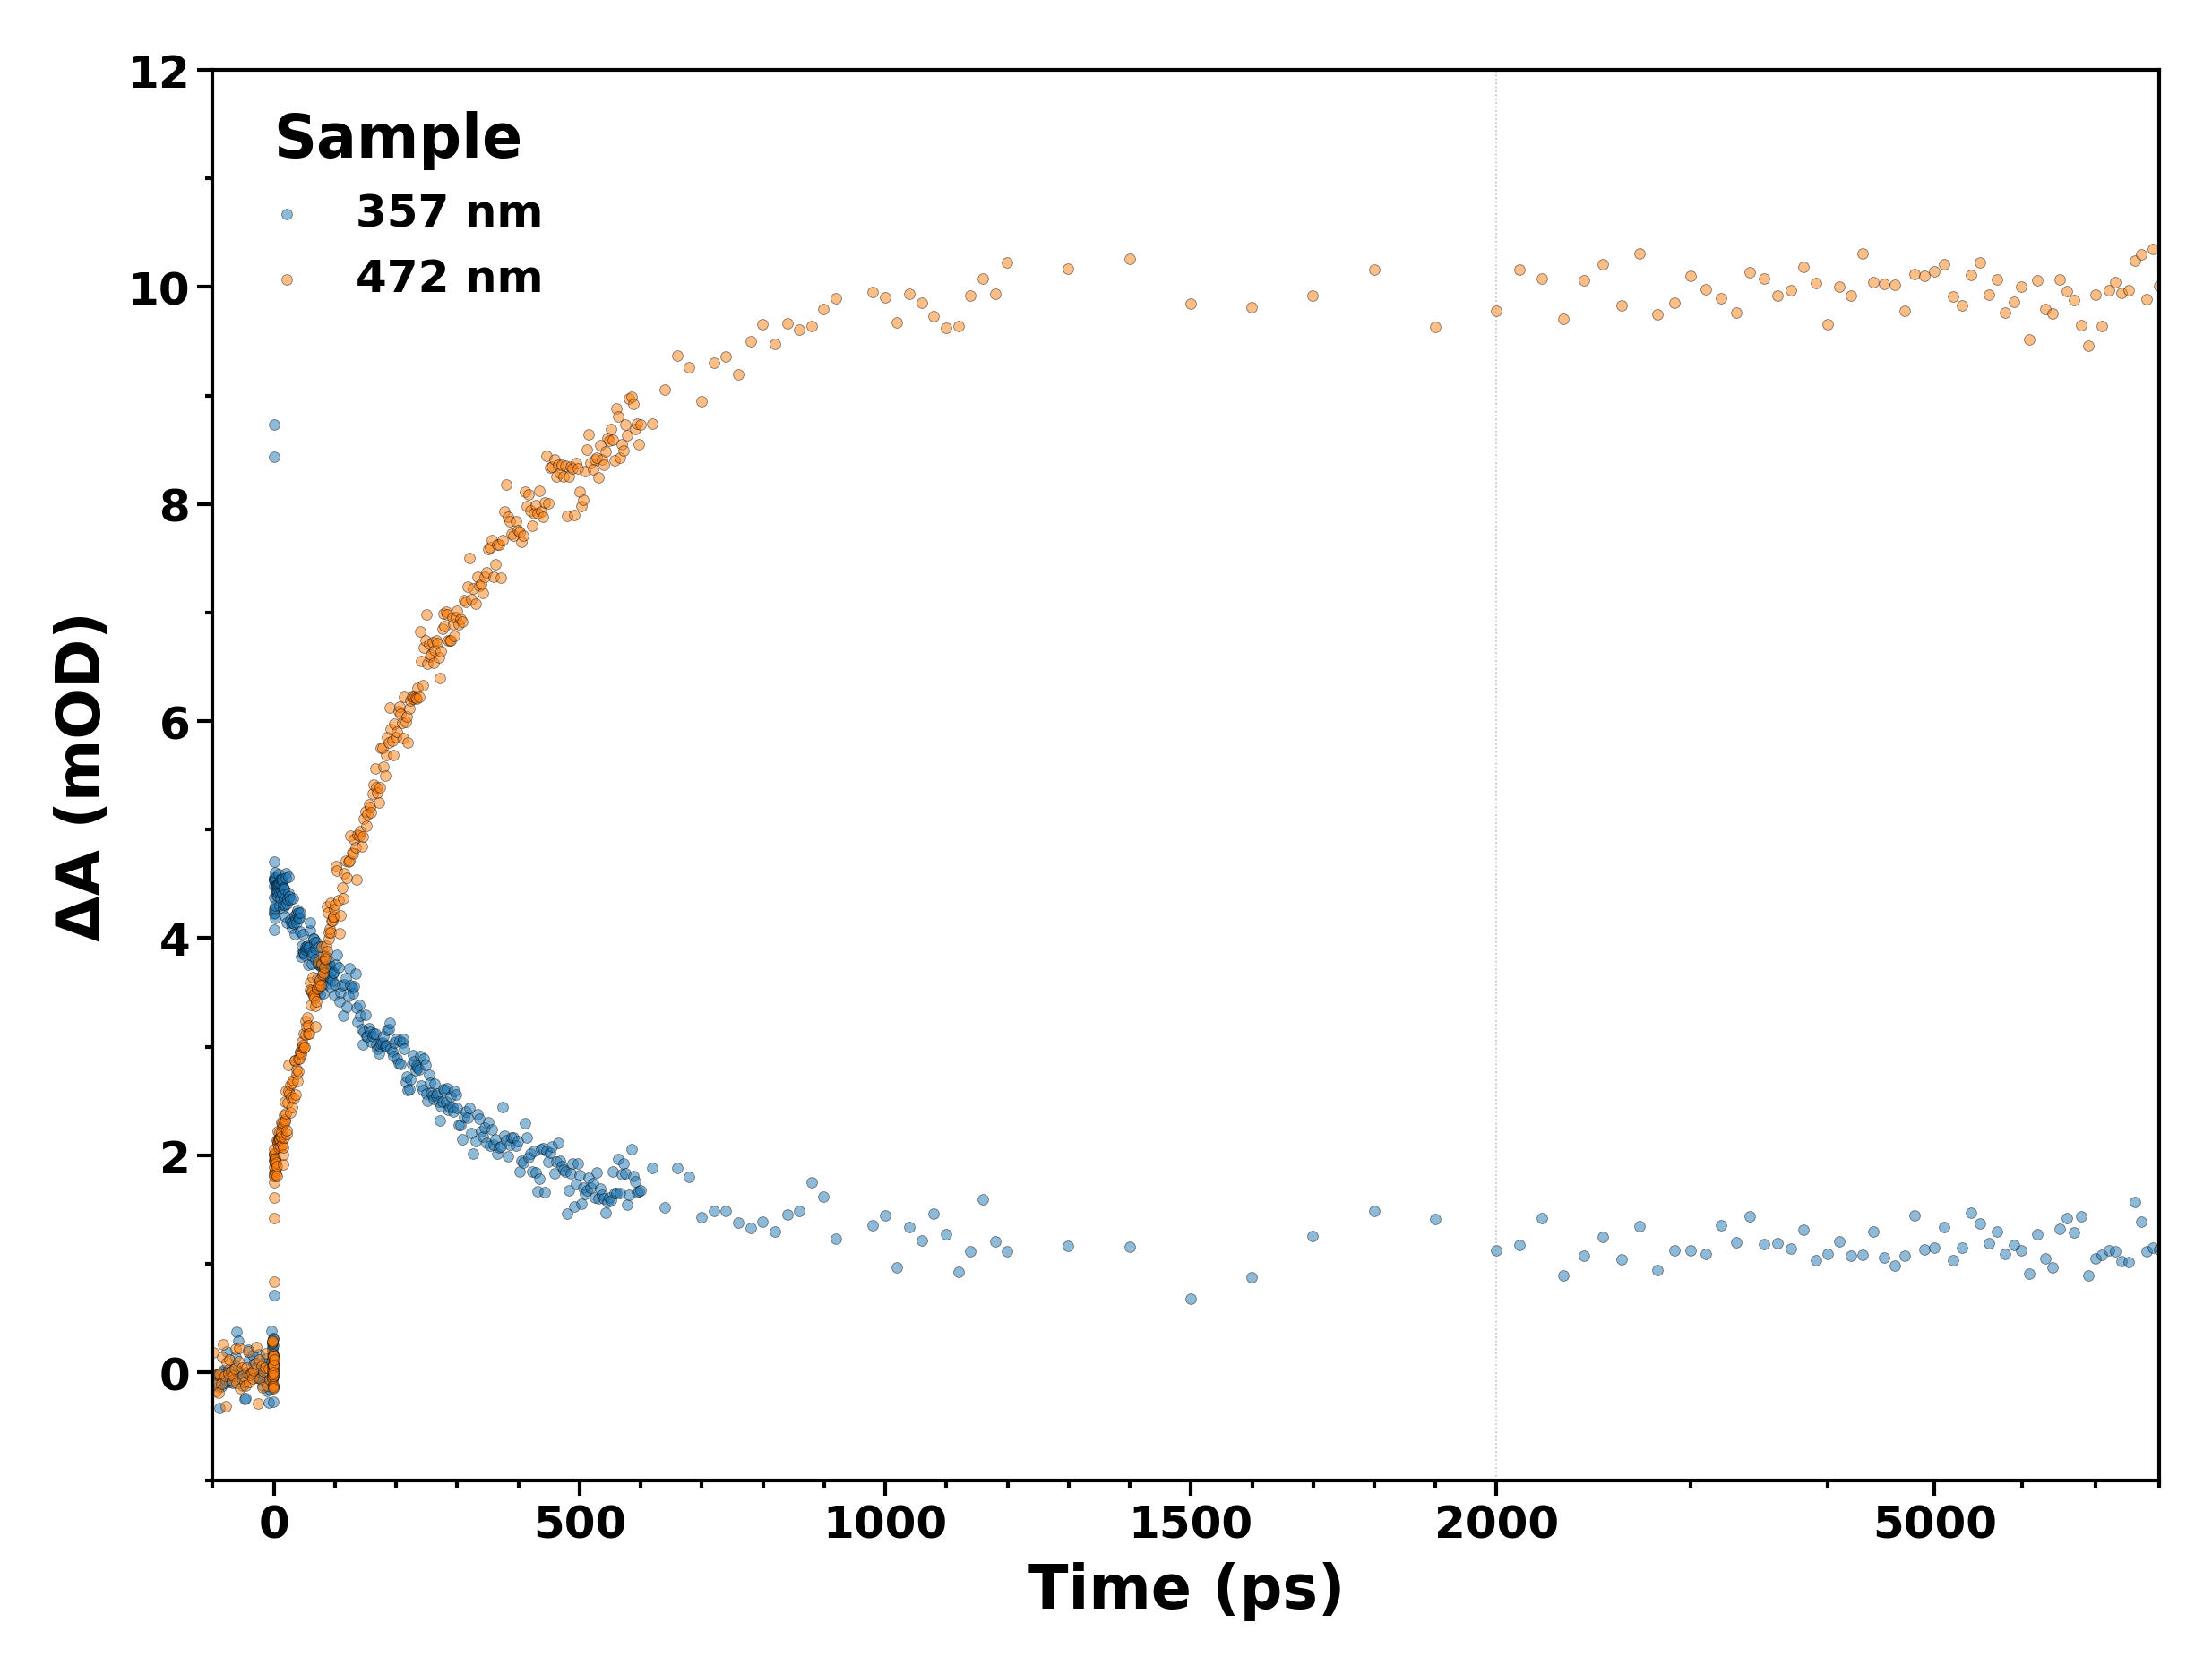

In [5]:
# reload(mp)
kinetics_t_limit = [[-100, 2000, 8000], 500, 100]
kinetics_od_limit = [[-1, 12], 2, 1]

wavelengths = [357, 472]  # set the wavelengths for extracting kinetics
kinetics = mins.extract_2colkinetics_trspectra(data, wavelengths)
# display(kinetics)
# mp.preview_2coldf(kinetics)
mp.display_fsta_2colkinetics_symlog(
    kinetics,
    legendtitle=sample,
    xlimit=kinetics_t_limit,
    ylimit=kinetics_od_limit,
    legendposition="upper left",
)
plt.show()

#  Single Wavelength Fitting


In [6]:
func = "GPdfConHDExp"  # fitting function
fits = []

# set a loop for fitting kinetics at each wavelength
# be aware that the initial parameters and bounds might not suit each wavelength
for i in range(int(kinetics.shape[1] / 2)):
    fit = mm.fit_fsta_2colkinetics(
        data=kinetics.iloc[:, [2 * i, 2 * i + 1]],
        func_name=func,
        p0=[0, 0, 0.2, 5, 300, 3, 50000],
        # bounds=(
        #     [-0.00001, -2, -1, 0, 295, 0, 0],
        #     [0.00001, 2, 1, np.inf, np.inf, np.inf, np.inf],
        # ),
        yaxistype="linear",
    )
    fits.append(fit[0])

# if the loop fitting doesn't work, try fitting each wavelength separately
# fit1 = mm.fit_fsta_2colkinetics(
#     data=kinetics.iloc[:, 0:2],
#     func_name=func,
#     p0=[0, 0, 0.2, 5, 300, 3, 50000],
#     bounds=(
#         [-0.00001, -2, -1, 0, 295, 0, 0],
#         [0.00001, 2, 1, np.inf, np.inf, np.inf, np.inf],
#     ),
#     yaxistype="linear",
# )
# fits.append(fit1[0])

# fit2 = mm.fit_fsta_2colkinetics(
#     data=kinetics.iloc[:, 2:],
#     func_name=func,
#     p0=[0, 0, 0.2, -3, 300, 12, 50000],
#     bounds=(
#         [-0.00001, -1, 0, -np.inf, 0, 0, 40000],
#         [0.00001, 1, 1, 0, np.inf, np.inf, np.inf],
#     ),
#     yaxistype="linear",
# )
# fits.append(fit2[0])

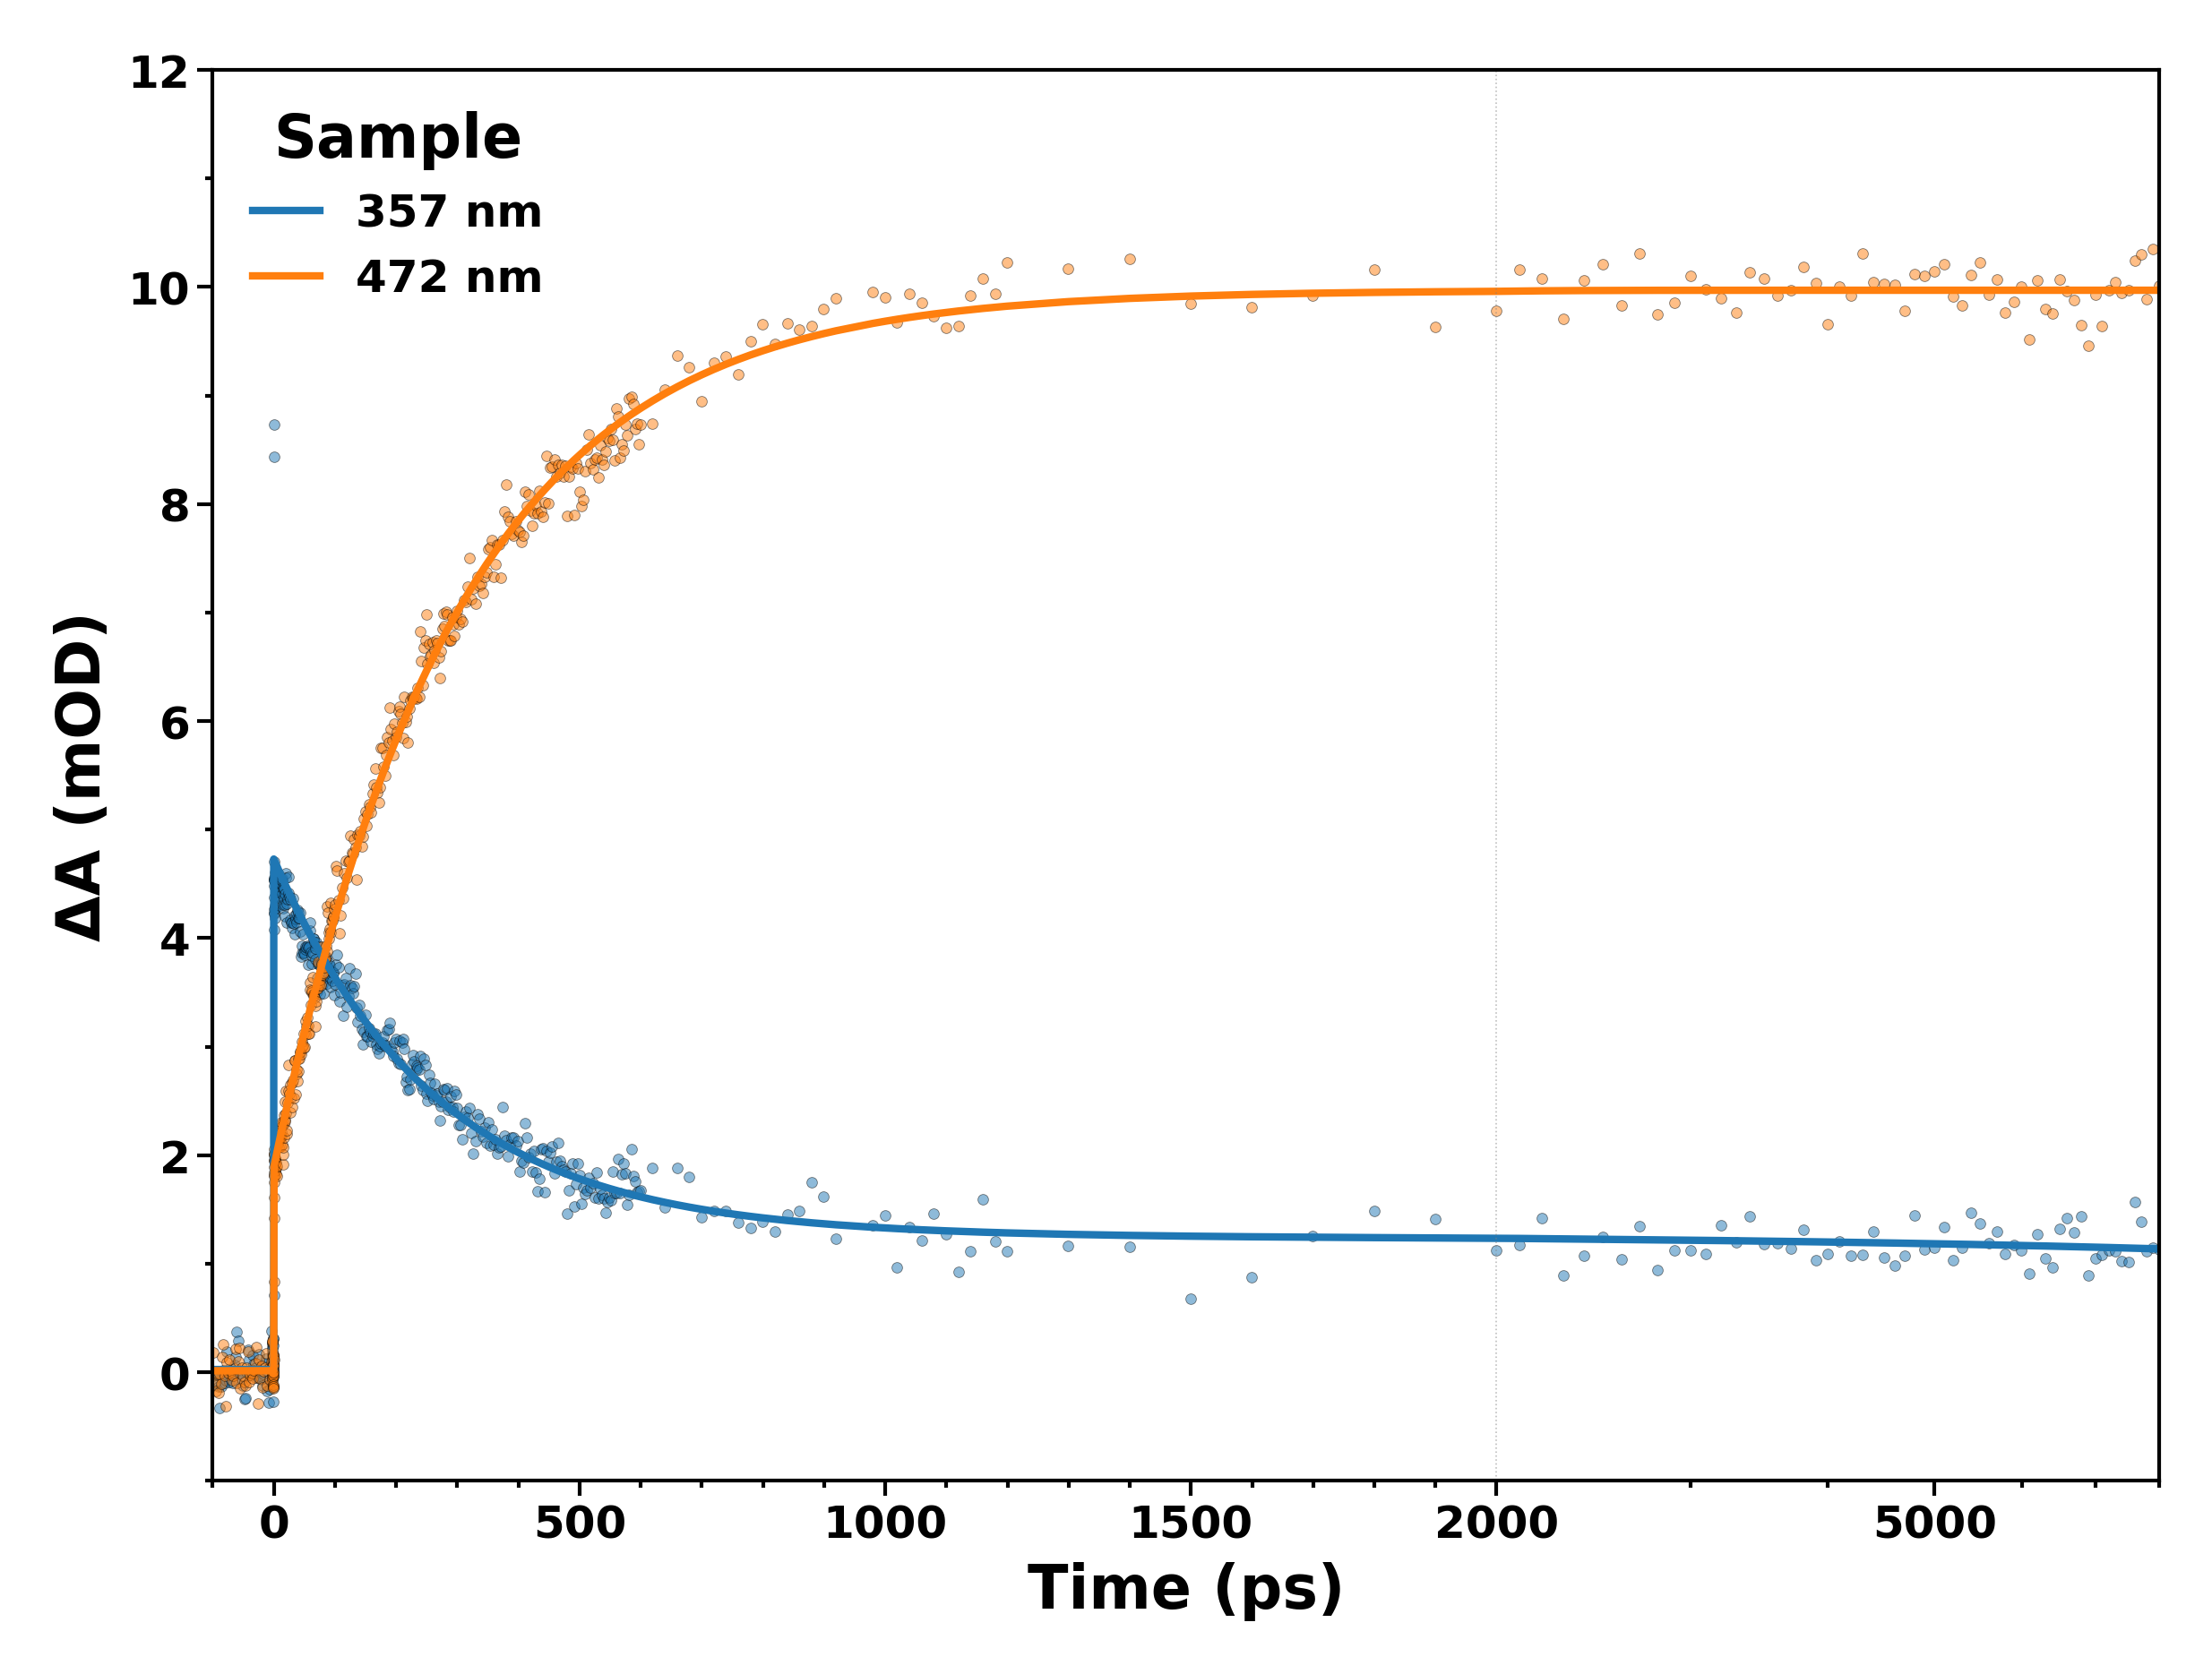

In [7]:
mp.display_fsta_1colkinetics_fitted_symlog(
    fits,
    xlimit=kinetics_t_limit,
    ylimit=kinetics_od_limit,
    legendtitle=sample,
    legendposition="upper left",
    # showwn=True,
)
plt.show()

# Global Analysis


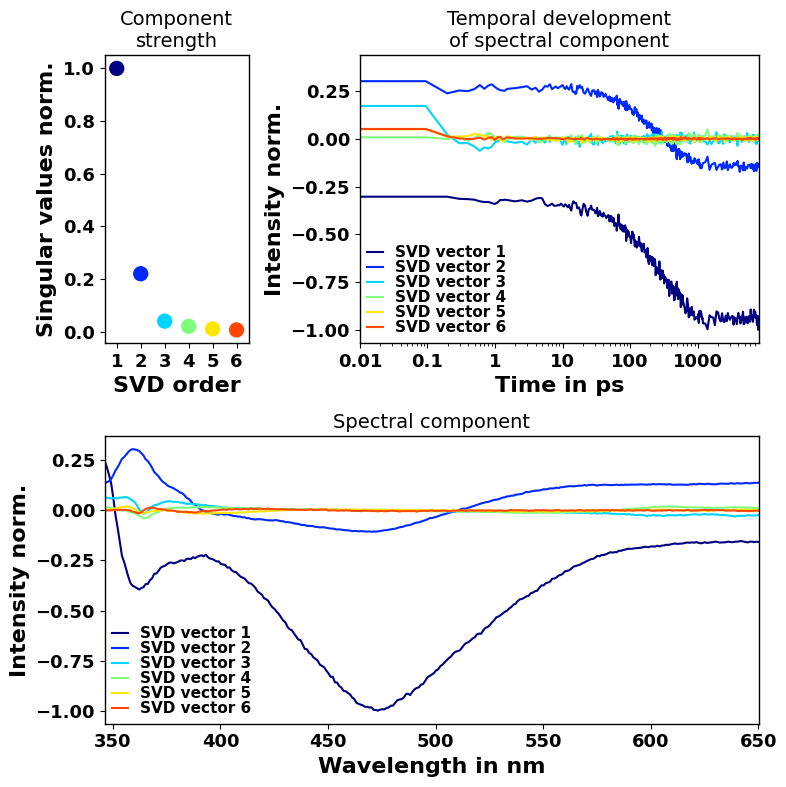

In [8]:
# plt.close("all")

ta = pf.TA(filename=sample, ds=data.T, sep=",", transpose=False)
# ta.lintresh = 100

# spectra
ta.wave_nm_bin = 1
ta.rel_time = delaytime1 + delaytime2
# ta.time_width_percent=0
# ta.timelimits = [ylimit[0][0], ylimit[0][2]]
ta.timelimits = [-100, 8000]
# ta.ignore_time_region=[-0.5, 0.5]
ta.bordercut = nm_limit[0]  # wavelength range

# kinetics
ta.wavelength_bin = 1
ta.rel_wave = wavelengths
# ta.scattercut=[300, 325]

# DA
ta.cmap = pf.cm.jet
ta.intensity_range = od_limit[0]
# ta.log_scale=False
# display(ta.ds)

# fit
ta.error_matrix_amplification = 10
ta.log_fit = False

# plot
# ta.log_scale=False
ta.Plot_RAW(
    plotting=[3],  # only ouput the result of SVD analysis
    # scale_type="symlog"
)
# ta.Plot_Interactive()

## Parallel Model


In [ ]:
ta.mod = "paral"  # or "exponential"
path = "p2"

ta.par = lmfit.Parameters()
ta.par.add("k0", value=1 / 300, vary=True)
ta.par.add("k1", value=1 / 150000, vary=True)
ta.par.add("t0", value=0, min=-1, max=1, vary=True)
ta.par.add("resolution", value=0.2, min=0, max=1, vary=False)
# ta.par.add("infinite")
# ta.par.add("background")

ta.Fit_Global(fit_chirp=False)
ta.Plot_fit_output(path=path)

ta.Save_data(
    save_RAW=False,
    path=path,
    filename=fn.replace(".csv", "") + "_" + path,
    sep=",",
)
# ta.Save_Plots(
#              path=os.getcwd()+"/parallelST",
#              savetype="pdf",
#              filename=filename.replace(".csv", "") + "_parallelST",
# )

## Sequential Model


Exception in thread Thread-5 (listen):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keyboard/__init__.py", line 294, in listen
    _os_keyboard.listen(self.direct_callback)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keyboard/_darwinkeyboard.py", line 430, in listen
    raise OSError("Error 13 - Must be run as administrator")
OSError: Error 13 - Must be run as administrator



Fit Results:
Model Used: consecutive

The minimum error is:8.90481921e+03
The minimum R2-value is:9.88613560e-01

In Rates

+------------+-------------+--------------+--------+-------+-------+--------+
|            |       value |   init_value | vary   |   min |   max | expr   |
+============+=============+==============+========+=======+=======+========+
| k0         | 0.00333651  |   0.00333333 | True   |     0 |   inf |        |
+------------+-------------+--------------+--------+-------+-------+--------+
| k1         | 1.85629e-13 |   1e-07      | True   |     0 |   inf |        |
+------------+-------------+--------------+--------+-------+-------+--------+
| t0         | 0.00367822  |   0          | True   |    -1 |     1 |        |
+------------+-------------+--------------+--------+-------+-------+--------+
| resolution | 0.25        |   0.25       | False  |     0 |     1 |        |
+------------+-------------+--------------+--------+-------+-------+--------+

The rates conver

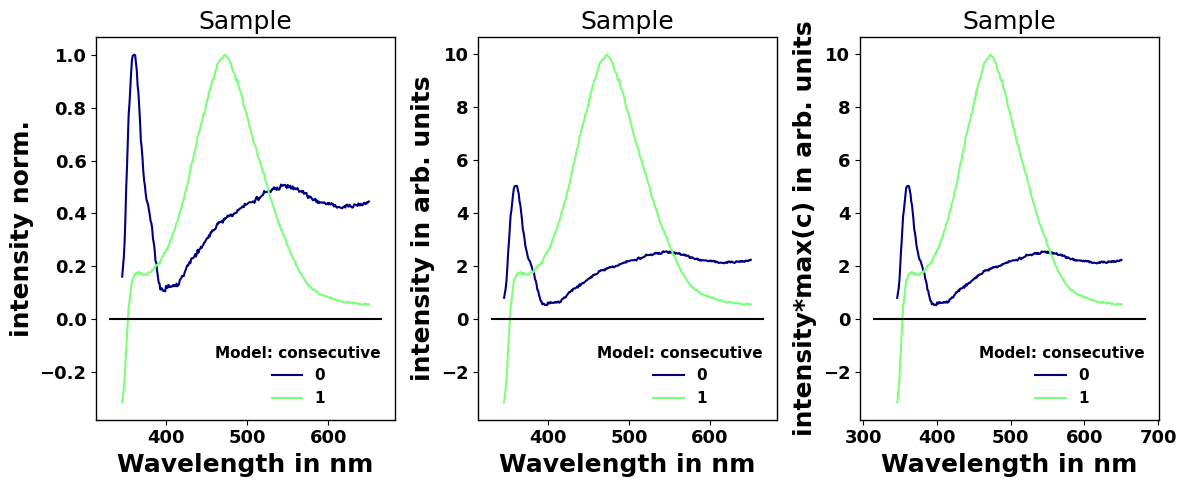

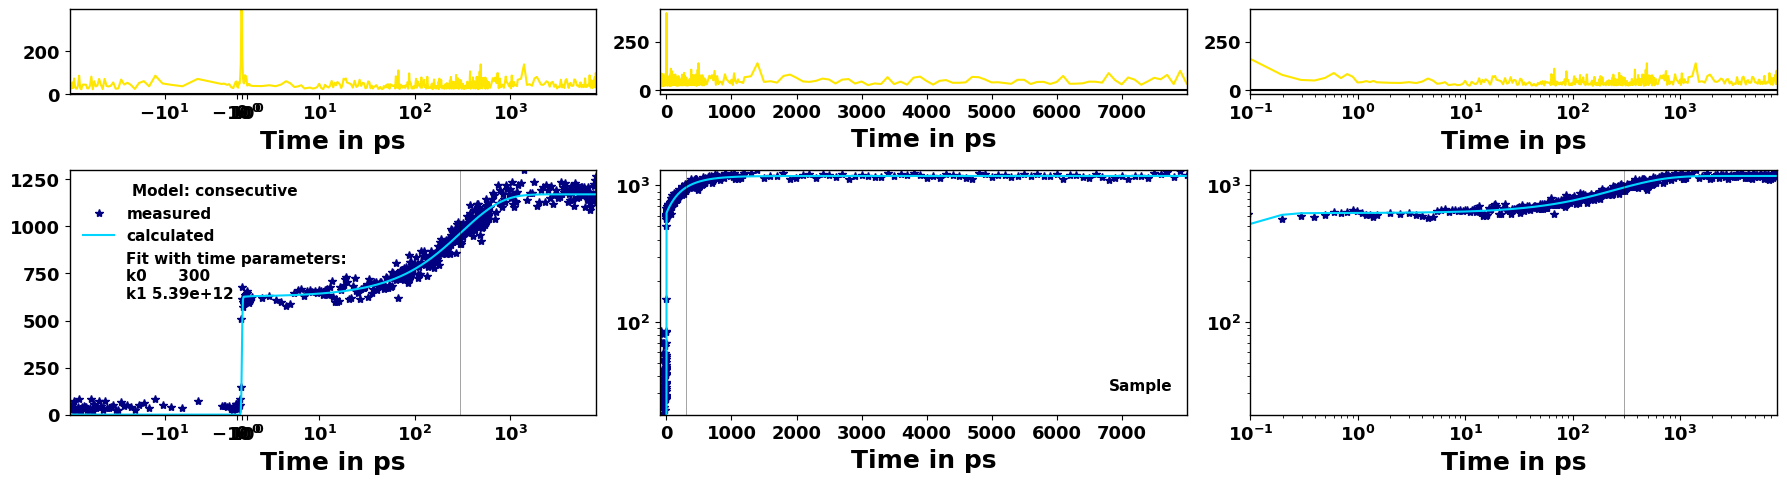

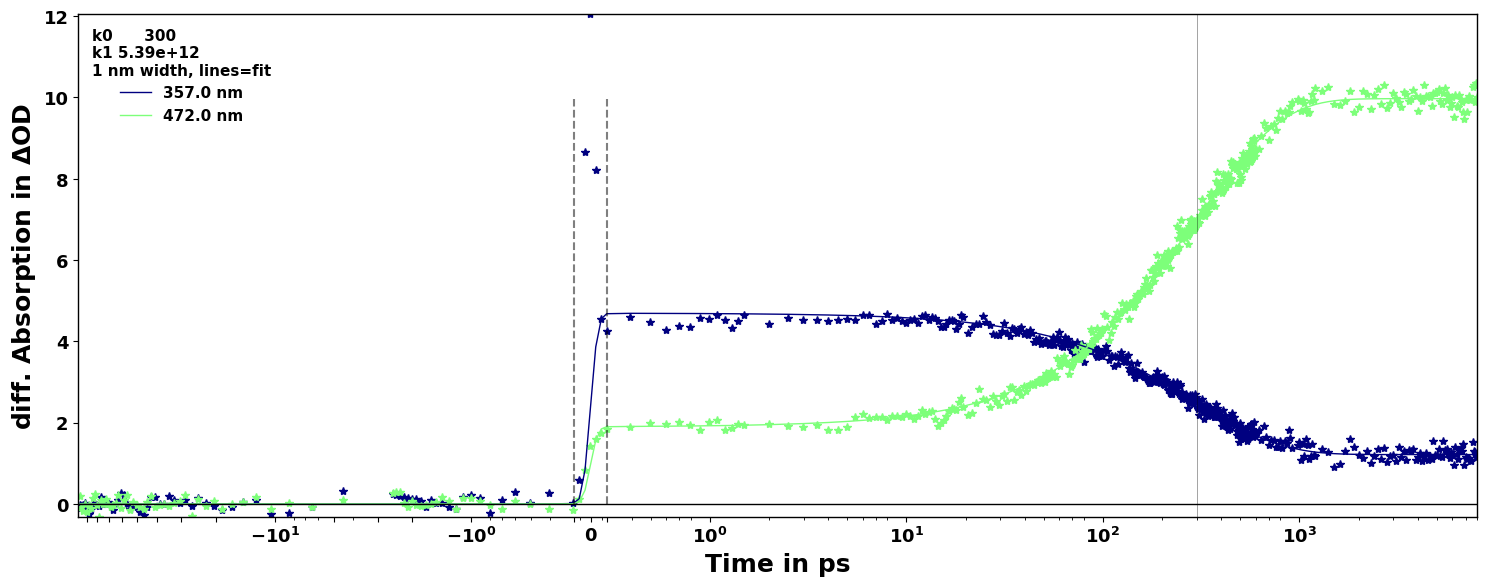

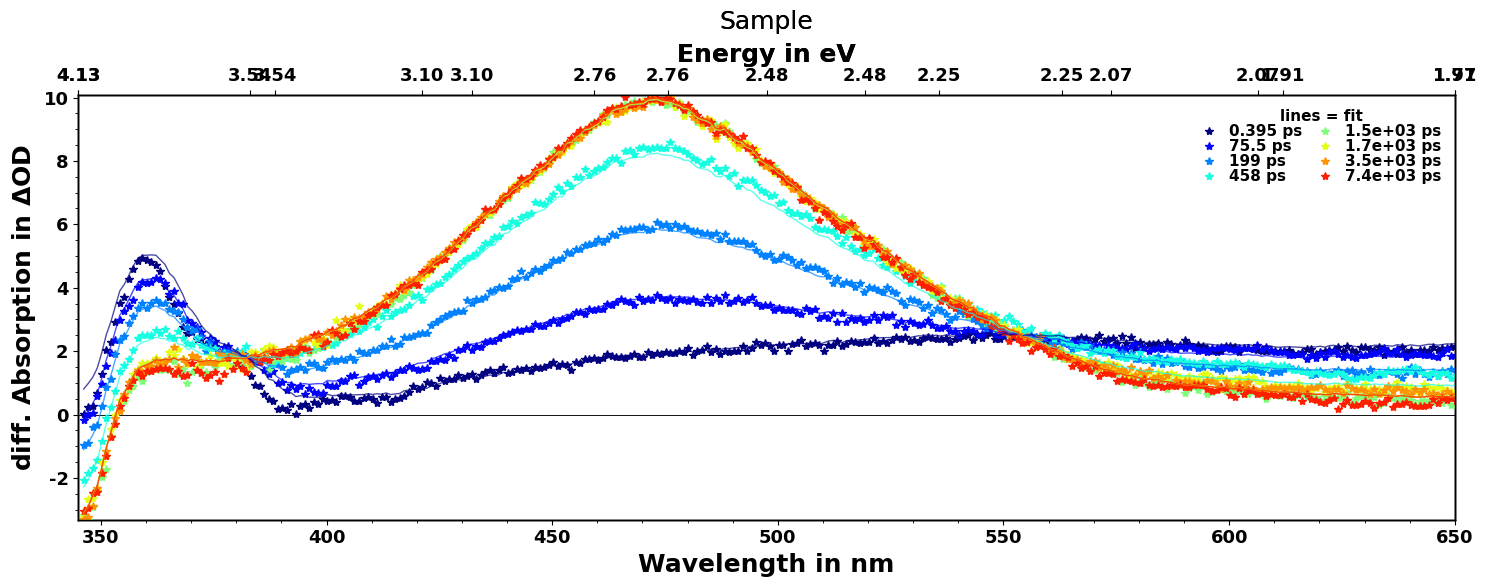

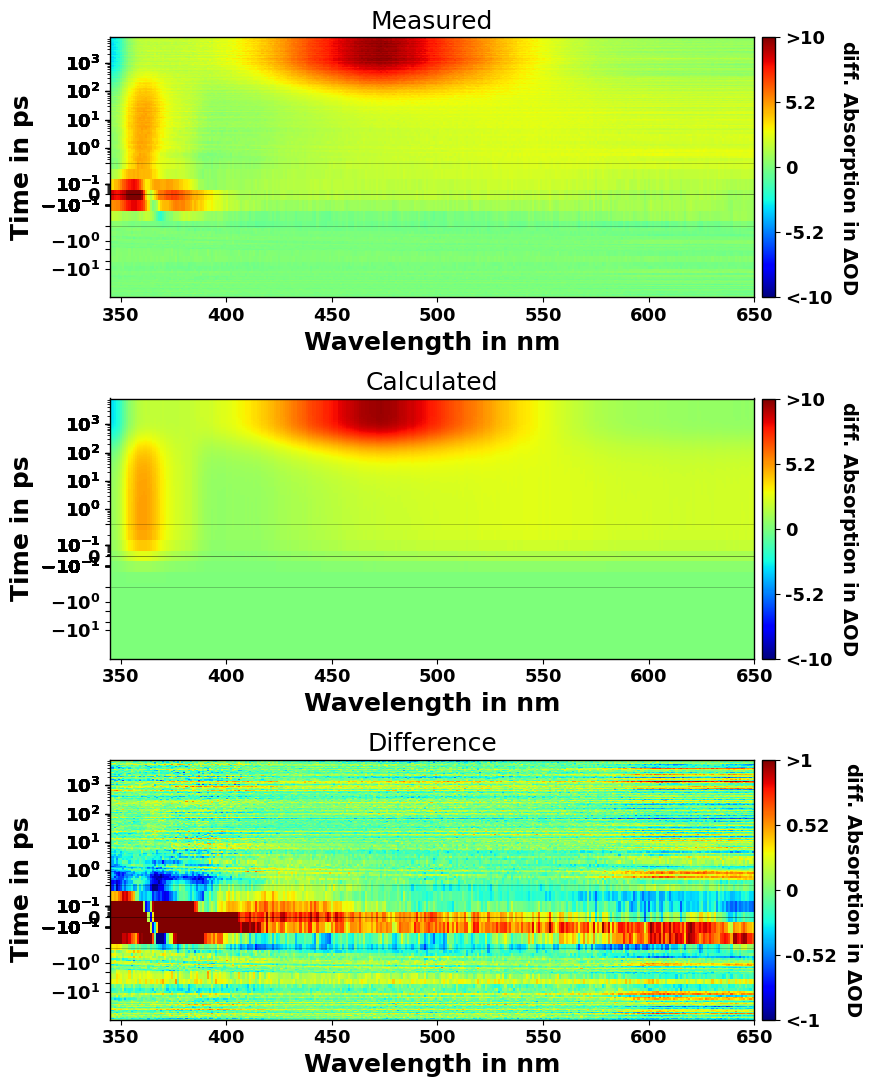

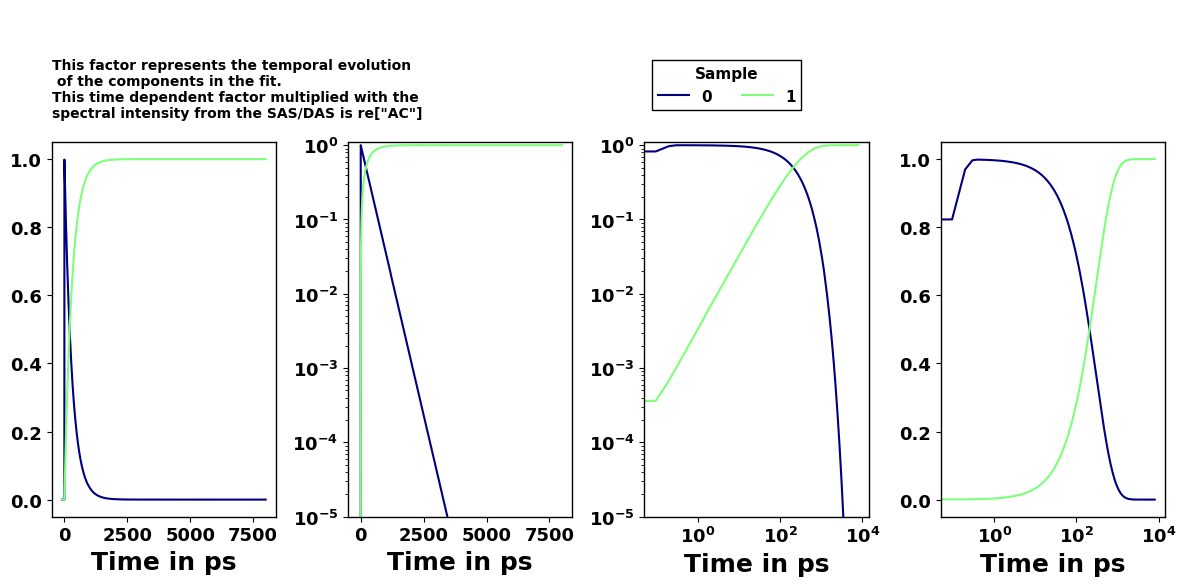

In [9]:
reload(mp)

ta.mod = "consecutive"
path = "g2"
ta.par = lmfit.Parameters()
ta.par.add("k0", value=1 / 300, vary=True)
ta.par.add("k1", value=1 / 10000000, vary=True)
ta.par.add("t0", value=0, min=-1, max=1, vary=True)
ta.par.add("resolution", value=0.25, min=0, max=1, vary=False)
# ta.par.add("infinite")
# ta.par.add("background")

ta.Fit_Global(fit_chirp=False, sub_sample=20)
ta.Plot_fit_output(path=path)

ta.Save_data(
    save_RAW=False,
    path=path,
    filename=fn.replace(".csv", "") + "_" + path,
    sep=",",
)

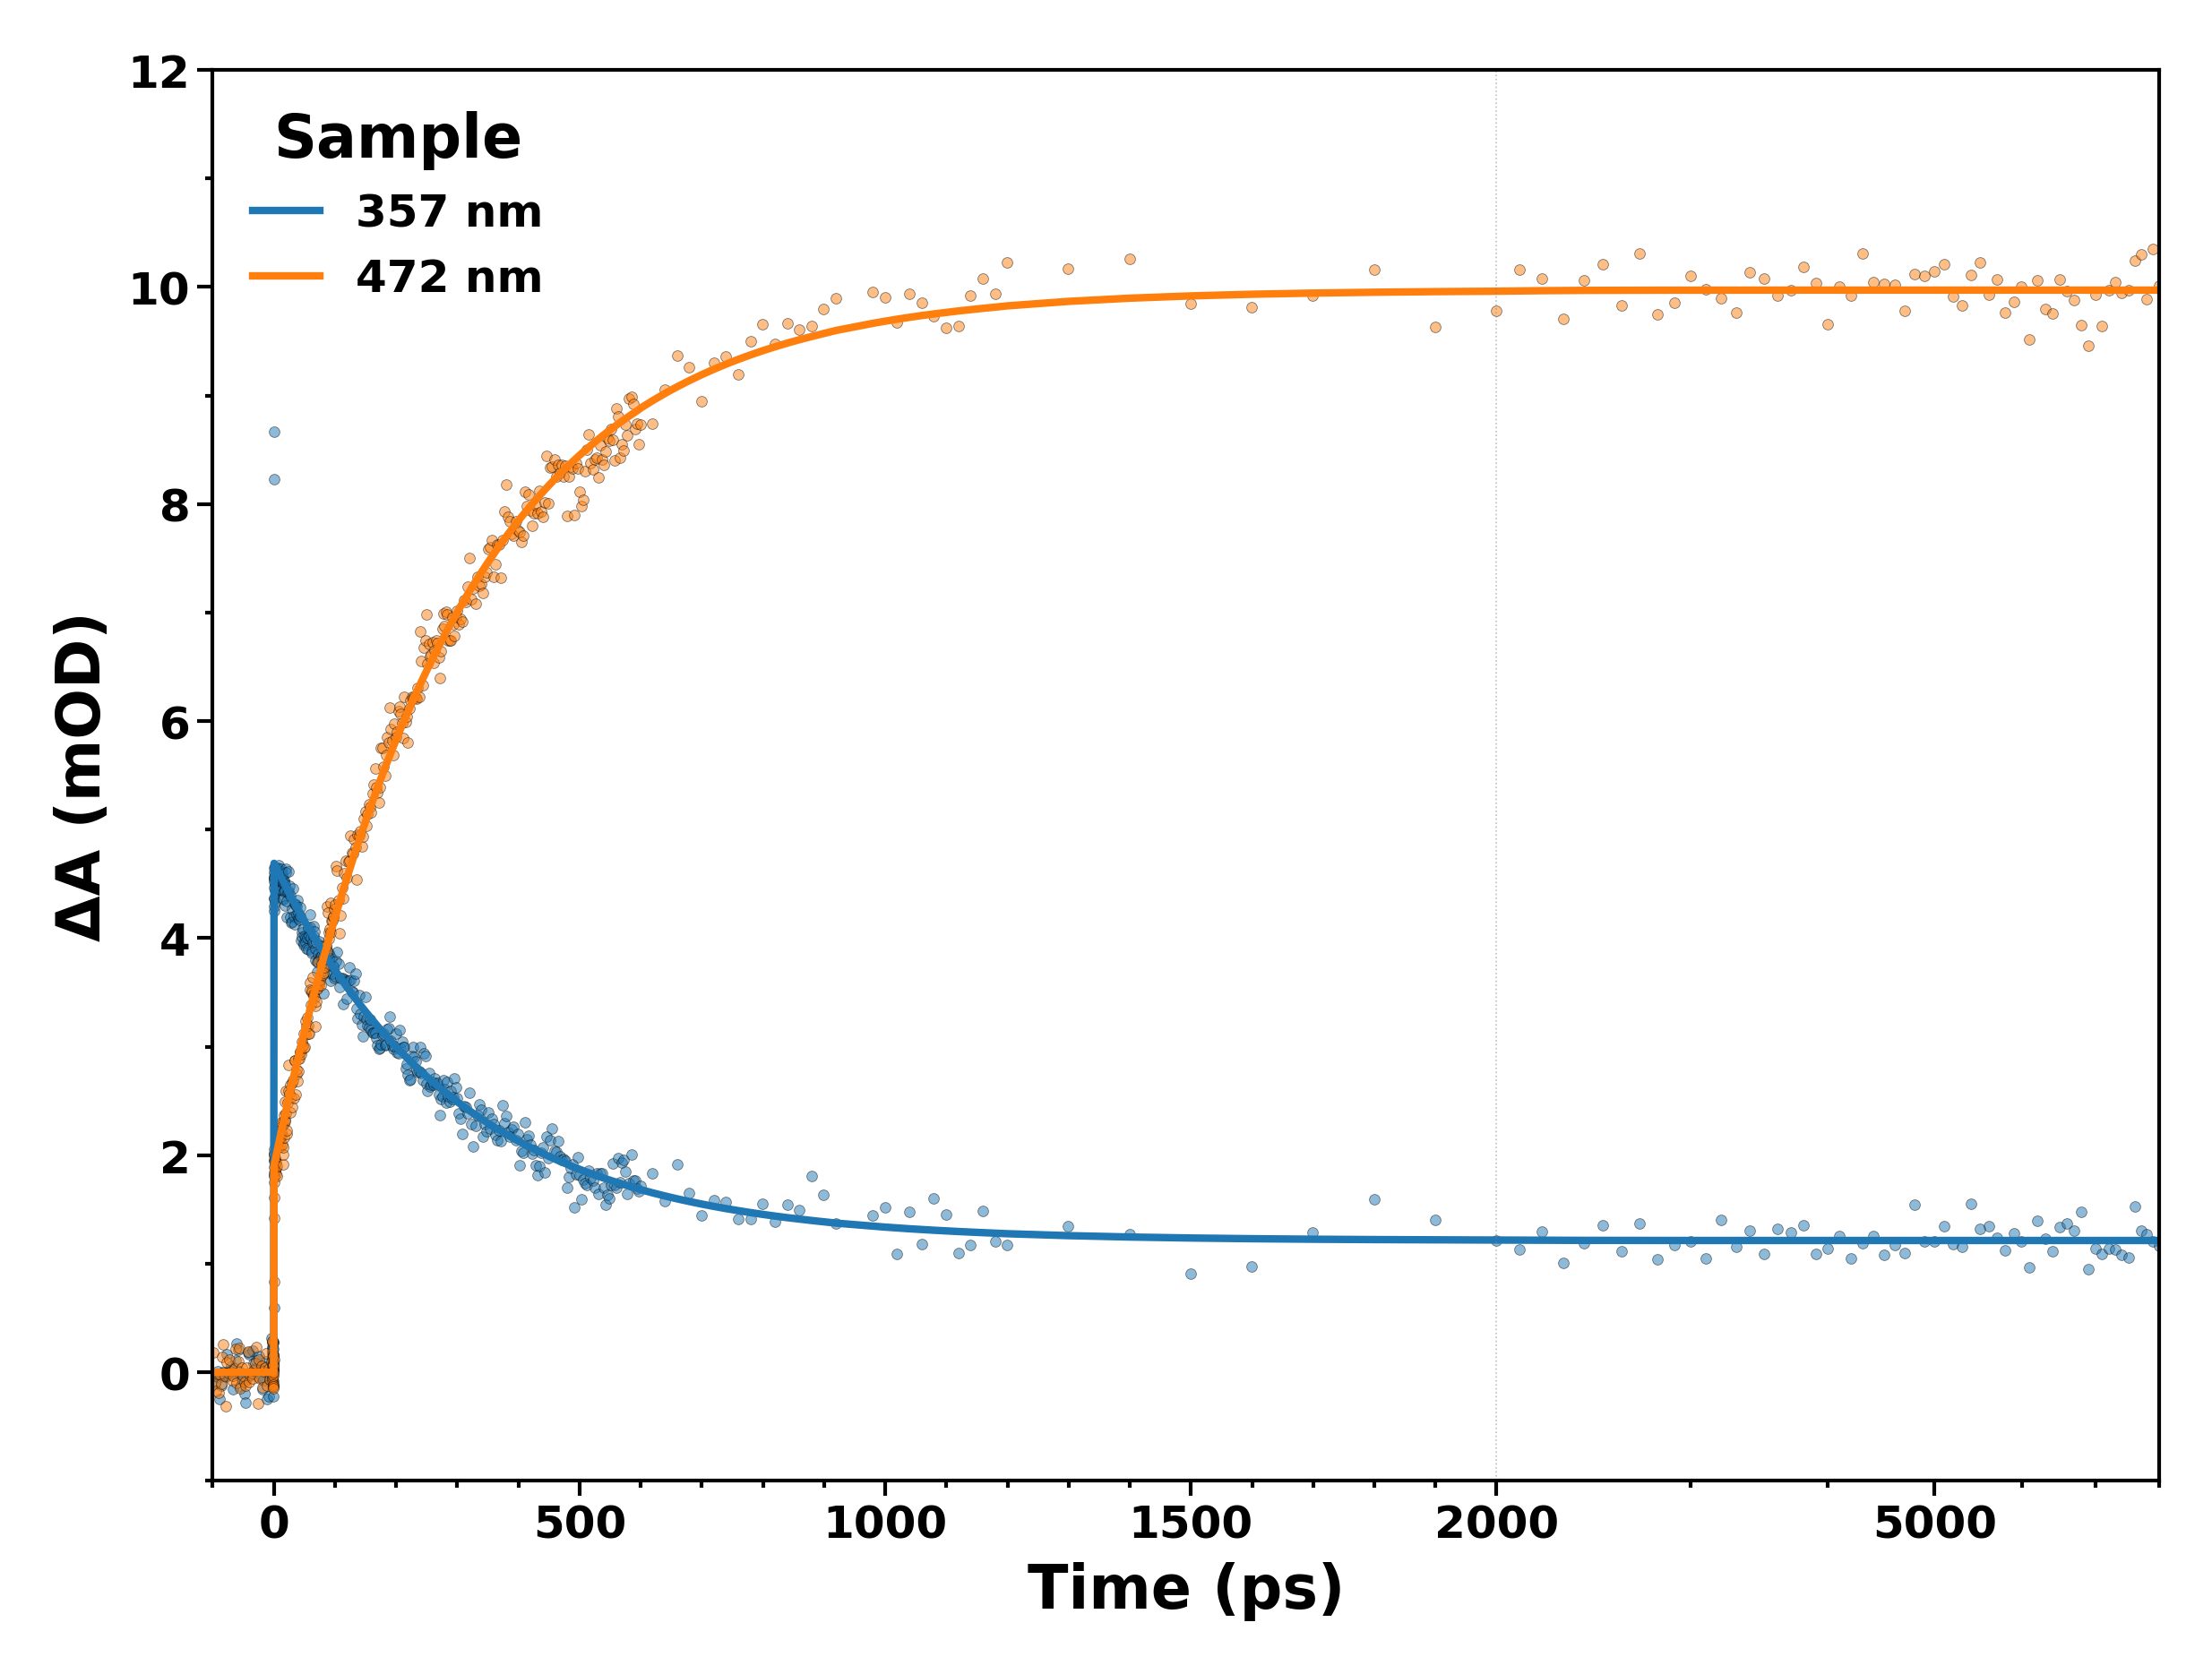

In [10]:
# reload(mp)

df_raw_kinetics = glob.glob("g2/*_measured_kinetics.dat")
# display(df_raw_kinetics)
df_raw_kinetics = pd.read_csv(df_raw_kinetics[0], header=0, index_col=0, sep=",")
# display(df_raw_kinetics)
# mp.preview_1col_df(df_raw_kinetics)

df_fit_kinetics = glob.glob("g2/*_fitted_kinetics.dat")
# display(df_fit_kinetics)
df_fit_kinetics = pd.read_csv(df_fit_kinetics[0], header=0, index_col=0, sep=",")
# display(df_fit_kinetics)
# mp.preview_1col_df(df_fit_kinetics)

list_df_raw_fit_kinetics = mf.combine_data_fit_kinetics(
    df_raw_kinetics, df_fit_kinetics
)
# display(list_df_raw_fit_kinetics)

mp.display_fsta_1colkinetics_fitted_symlog(
    list_df_raw_fit_kinetics[:2],
    xlimit=kinetics_t_limit,
    ylimit=kinetics_od_limit,
    legendposition="upper left",
    legendtitle=sample,
    # showwn=True,
)
plt.show()

/Users/tm/Downloads/sample_solvent_ar_fsta_330ex_caf2_100uw_it1000ms_depolarizer/min_function.py:673: RuntimeWarning:

divide by zero encountered in divide



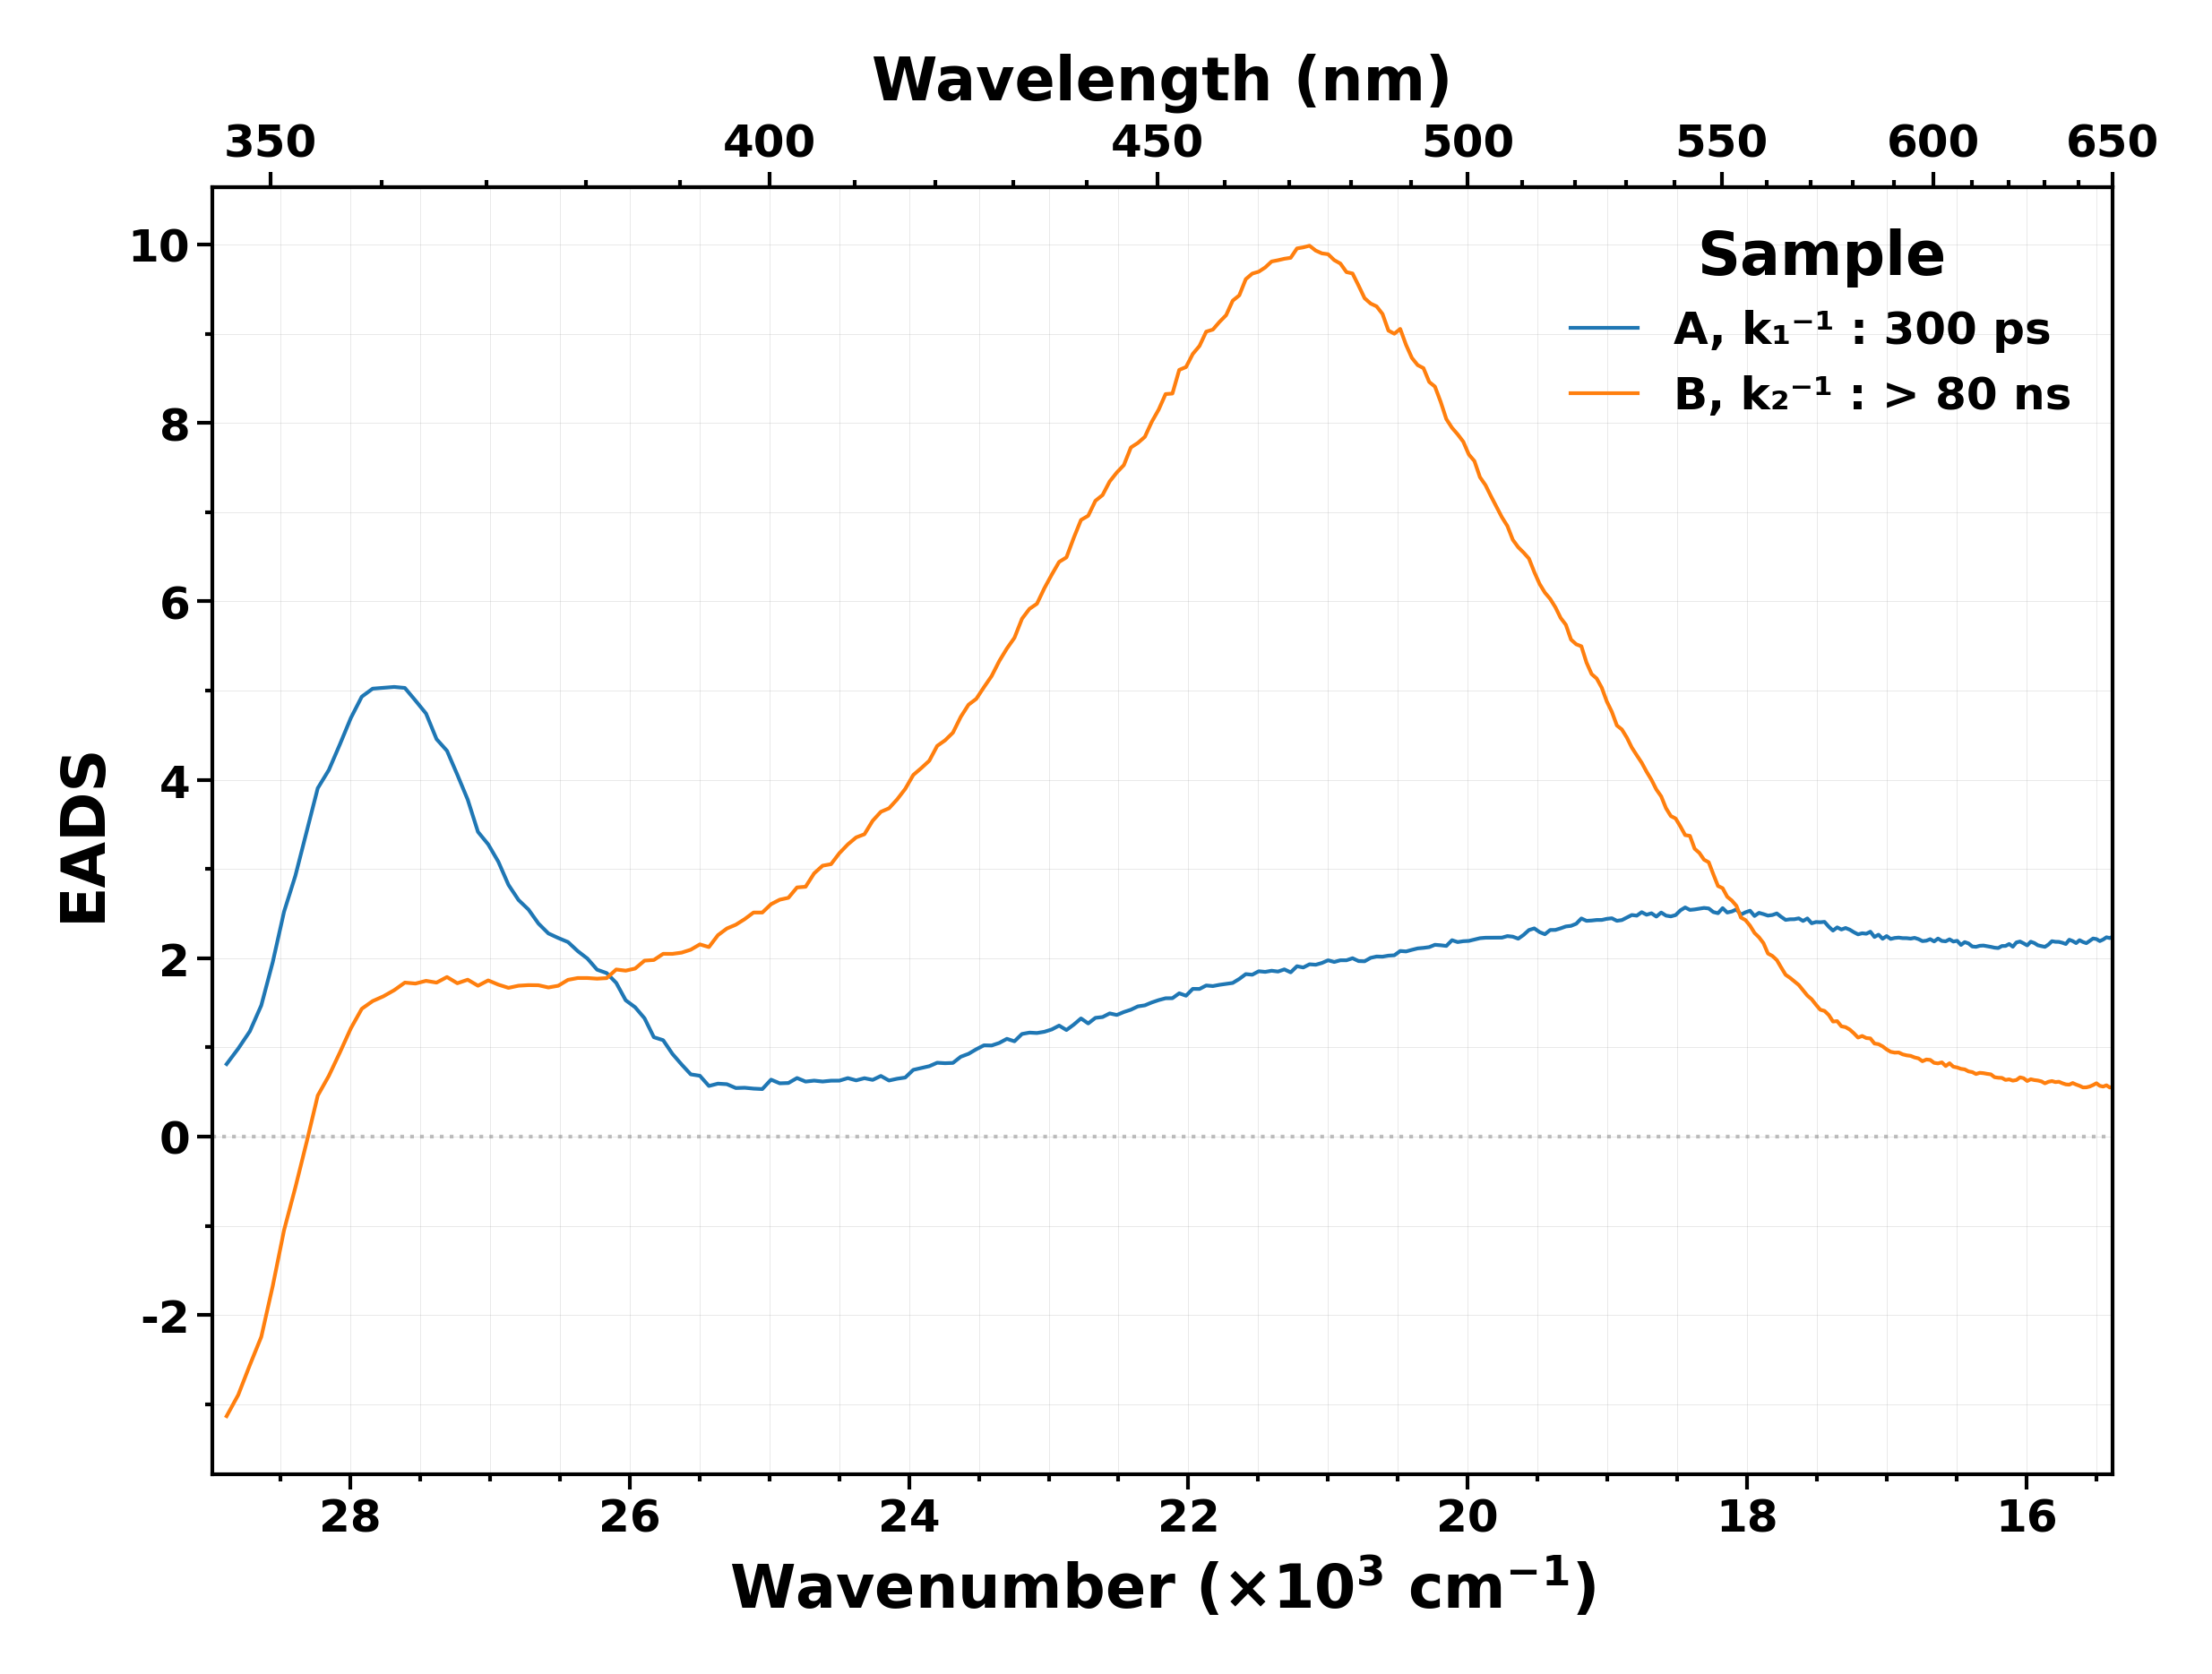

In [11]:
# reload(mp)

df_eads = ta.re["DAC"]
# mp.preview_1coldf(df_eads)
tau1 = mf.formalize_fsta_delaytime(ta.re["fit_results_times"].iloc[0, 0])
tau2 = mf.formalize_fsta_delaytime(ta.re["fit_results_times"].iloc[1, 0])
# display(tau1, tau2)

fig_eads = mp.display_fsta_globalfit_spectra_be3cm1_tnm(
    df_fstas_wl=df_eads,
    xlimit=e3cm1_limit,
    legendtitle=sample,
    legendtext=[
        f"A, k\u2081\u207b\u00b9 : {tau1}",
        f"B, k\u2082\u207b\u00b9 : {tau2}",
    ],
)
plt.show()

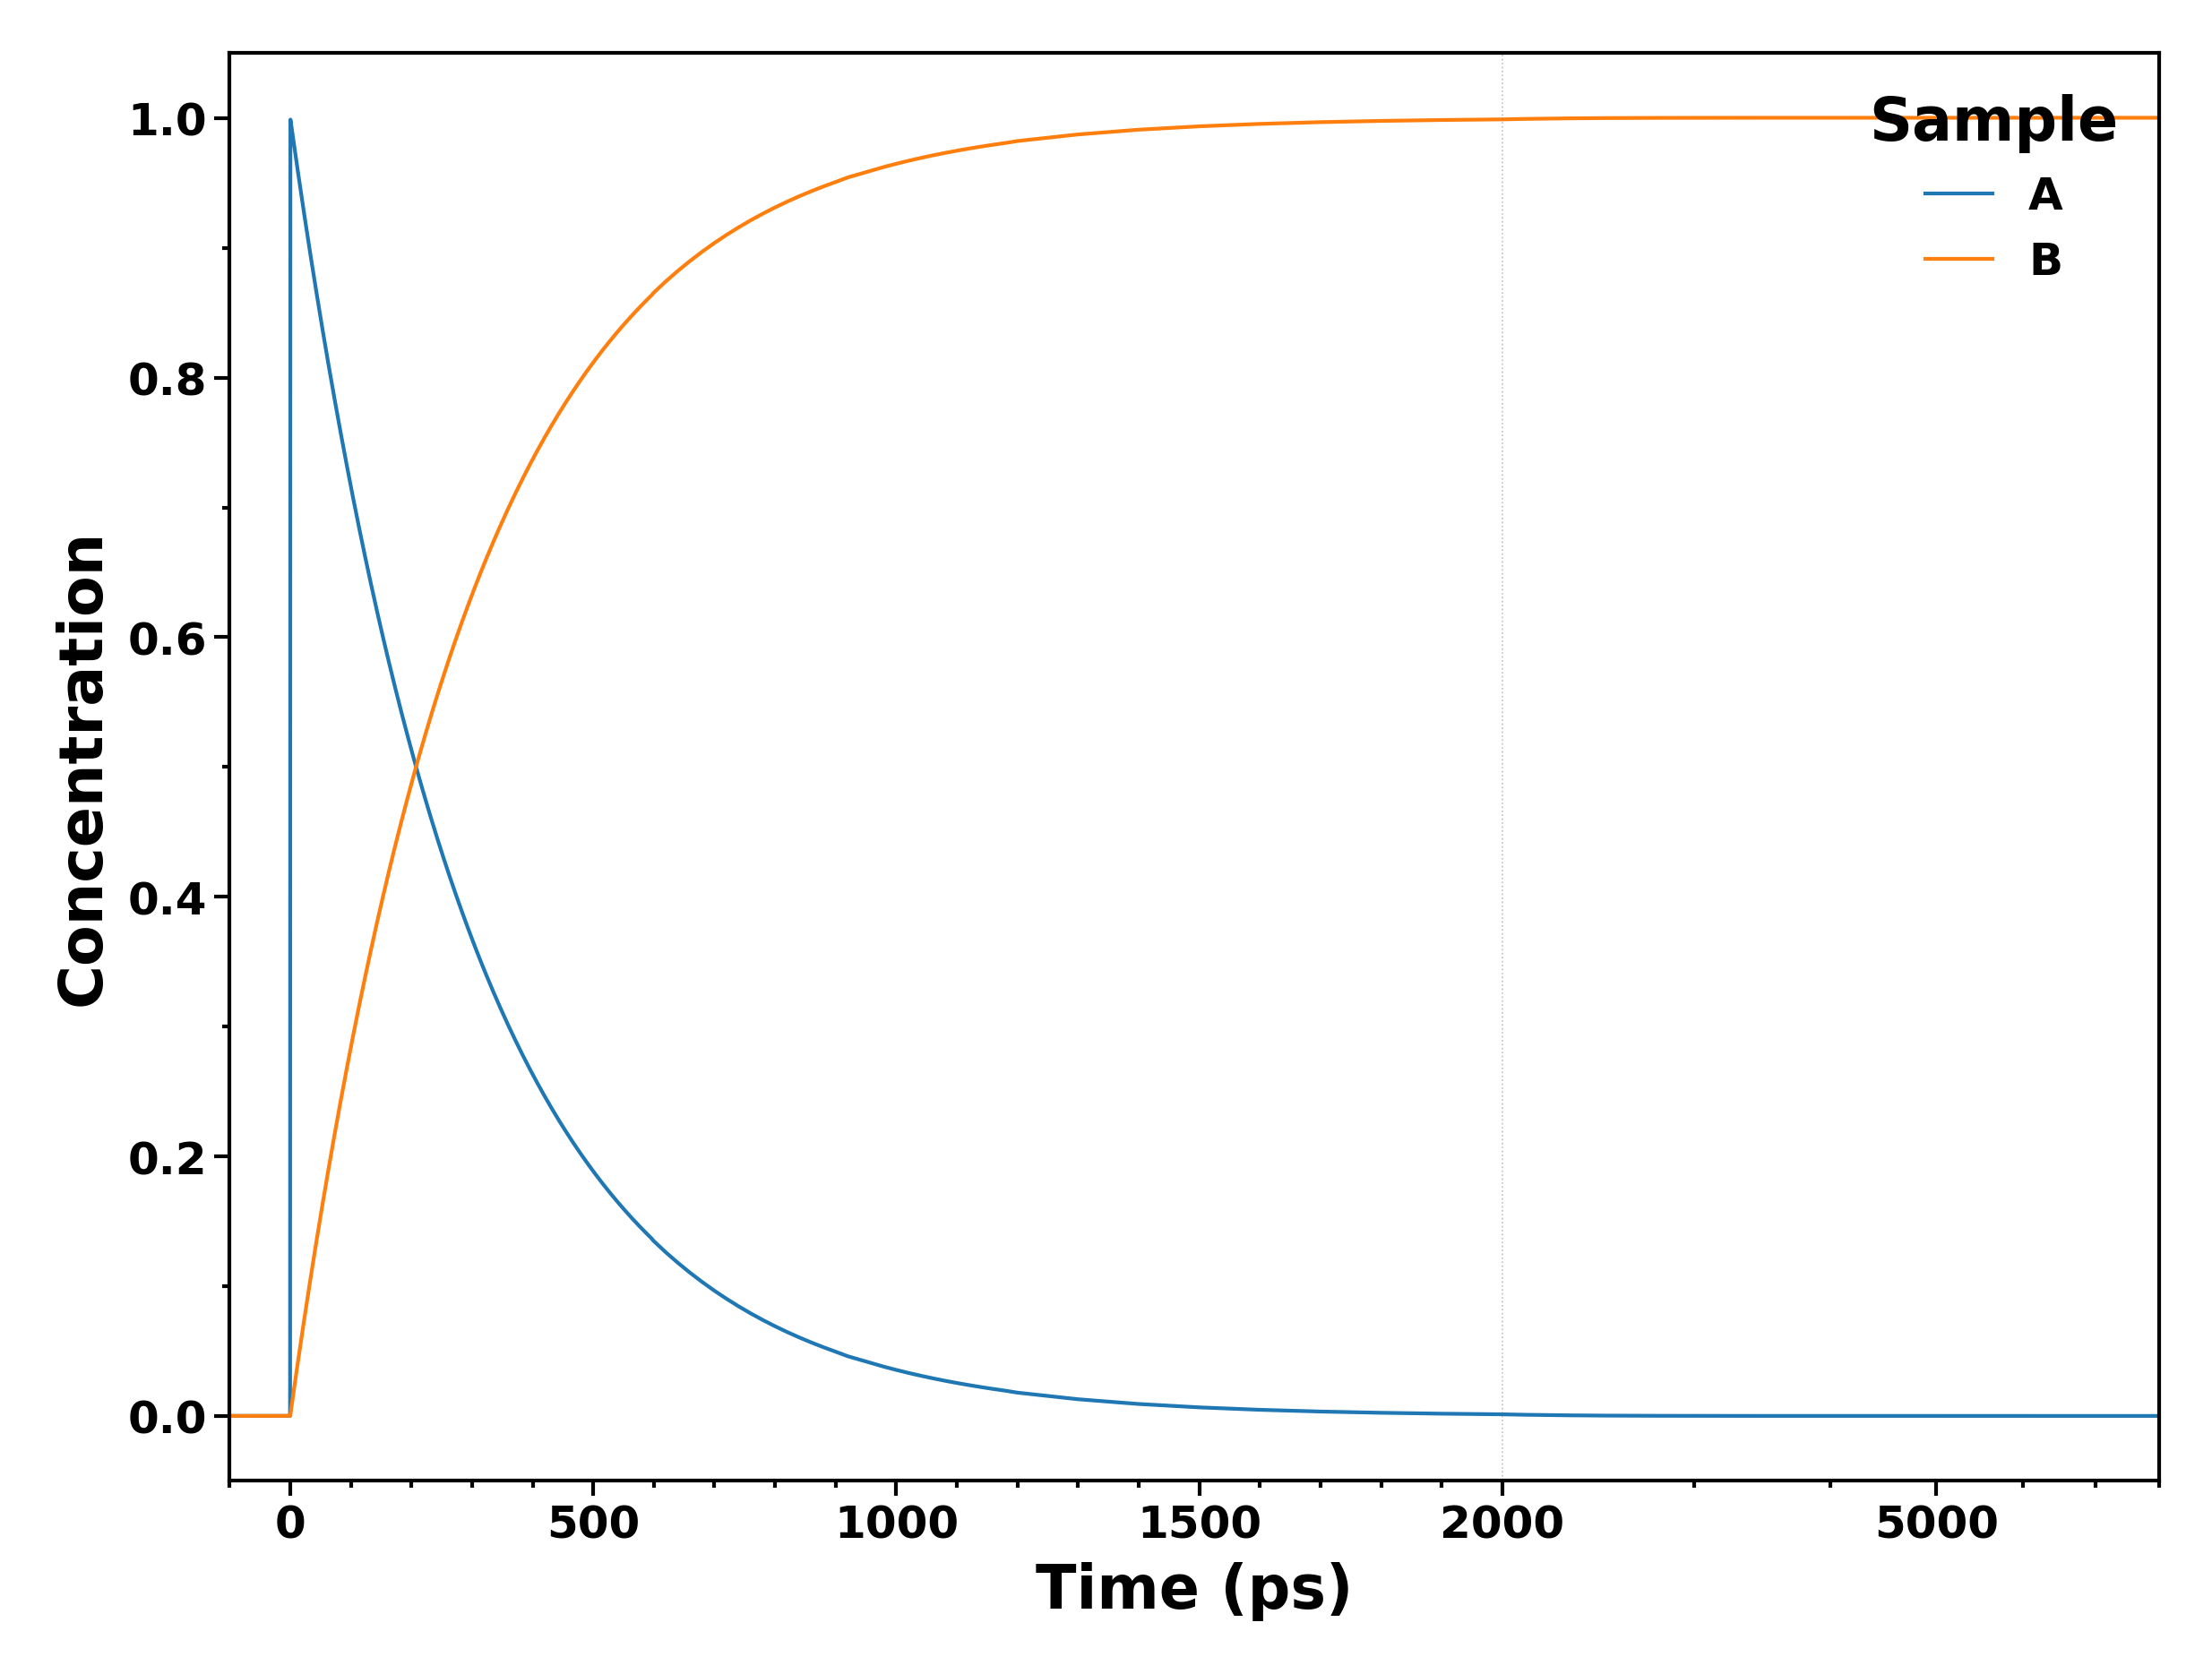

In [12]:
# reload(mp)

df_c = ta.re["c"]
# mp.preview_1coldf(df_c)

fig_c = mp.display_fsta_globalfit_concentration_symlog(
    df_1col=df_c,
    xlimit=kinetics_t_limit,
    legendtitle=sample,
    legendtext=["A", "B"],
)
plt.show()

## Target Model


In [ ]:
ta.mod = mm.targetST
path = "t2"
# k0: s1 decay
# k1: ISC
# k2: t1 decay
ta.par = lmfit.Parameters()
ta.par.add("k0", value=1 / 4600, vary=True)
ta.par.add("k1", value=1 / 8, vary=True)
ta.par.add("k2", value=1 / 4600, vary=True)
ta.par.add("t0", value=0, min=-1, max=1, vary=True)
ta.par.add("resolution", value=0.20, min=0, max=1, vary=True)
ta.Fit_Global(fit_chirp=False, sub_sample=10)
ta.Plot_fit_output(path=path)

ta.Save_data(
    save_RAW=False,
    path=path,
    filename=fn.replace(".csv", "") + "_" + path,
    sep=",",
)